In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

<module 'utils' from '/cndd2/fangming/projects/SingleCellRoutines/utils.py'>

In [2]:
today = datetime.date.today()
figures = '../figures/{}_{{}}'.format(today)
figures

'../figures/2021-07-09_{}'

# read in processed data

In [3]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [4]:
!ls ../data/

clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
clustering_embedding_S1R2_2021-05-22.tsv.gz
clustering_embedding_S2R1_2021-05-22.tsv.gz
clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz
clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.tsv.gz
clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-04.tsv.gz
clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1hemibrainsections_2021-06-05.tsv.gz
palette_admouse.json
palette_clustering_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-06-02.json
palette.json
processed_merfish_ad_mouse_june2_2021.hdf5
processed_merfish_ad_mouse_rotated_june2_2021.hdf5
processed_vizgen_merfish_may1_2021.h5ad
processed_vizgen_merfish_may22_2021.hdf5
raw_admouse
S2R1_gene_cluster_lognormcounts.tsv
S2R1_gene_cluster_zscores.tsv
summary_tables_admouse


In [5]:
f = '../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
print(clsts.shape)
clsts.head()

(83546, 3)


cluster    umap_1    umap_2
cell                                                               
149164679103246548309819743981609972453      C2  3.681072 -3.253162
215843146921706462965382248182021894607     C16  4.133874 -4.346824
230248905804673613678286091156141465134     C16  4.128419 -3.864845
237155298815097057940587033798543926454     C13  3.333298 -6.567634
256099454901769634241742157204636917386     C16  4.180815 -4.491610

In [6]:
# file = '../data/processed_vizgen_merfish_may1_2021.h5ad'
file = '../data/processed_vizgen_merfish_may22_2021.hdf5'
samples = [
#     'Slice1_Replicate1',
#     'Slice1_Replicate2',
#     'Slice1_Replicate3',
    
    'Slice2_Replicate1',
#     'Slice2_Replicate2',
#     'Slice2_Replicate3',
    
#     'Slice3_Replicate1',
#     'Slice3_Replicate2',
#     'Slice3_Replicate3',
]


# data = {}
# for sample in samples:
#     thedata = pd.read_hdf(file, 'data_'+sample)
#     data[sample] = thedata 
    
gmat = []
meta = []
for sample in samples:
    _gmat = pd.read_hdf(file, 'mat_'+sample)
    gmat.append(_gmat)
    _meta = pd.read_hdf(file, 'meta_'+sample)
    _meta['sample'] = sample 
    meta.append(_meta)
gmat = pd.concat(gmat)
meta = pd.concat(meta)

In [7]:
# # informations
# thedata = clsts.join(thedata) #.join(clsts)
# metacols = thedata.columns[:14]
# genes = thedata.columns[14:]
# gmat = thedata.iloc[:,14:]
# print(metacols, len(genes), gmat.shape)

# informations
thedata = clsts.join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

483 (79420, 483) (83546, 16)


# plotting functions

In [8]:
def plot_umap_routine(ax, x, y, hue, toplot, palette=None, legend=False, title='', fontsize=12):
    """
    """
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    hue_order=np.sort(toplot[hue].unique()),
                    palette=palette,
                    s=2, 
                    alpha=0.9,
                    linewidth=0, 
                    rasterized=True, 
                    legend=legend, 
                    ax=ax,
                   )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)

    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'UMAP', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # # arrows
    return 

def plot_spatial_routine(ax, x, y, hue, toplot, palette=None, legend=False, title='', fontsize=12):
    """
    """
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    hue_order=np.sort(toplot[hue].unique()),
                    palette=palette,
                    s=2, 
                    alpha=0.9,
                    linewidth=0, 
                    rasterized=True, 
                    legend=legend, 
                    ax=ax,
                   )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    
    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # end arrows
    
    # scale bar
    length = 1000
    left = 3500
    length, left = 1000, 3500 
    ax.hlines(0.01, left, left+length, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(left+length, 0, '1 mm', 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return



In [9]:
def plot_continuous_umap_routine(
    ax, x, y, hue, toplot, vmaxp=99, palette=None, title='', fontsize=12, pth=50):
    """
    # colorbar
    norm = plt.Normalize(0, vmaxp)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm,)
    fig.colorbar(sm, cax=cax, label='Percentile', ticks=[0, vmaxp])
    """
    vmin, vmax = 0, np.percentile(toplot[hue], vmaxp)
    cmap = sns.cubehelix_palette(as_cmap=True)
    pth = np.percentile(toplot[hue], pth)
    
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    s=1, 
                    alpha=0.3,
                    linewidth=0, 
                    legend=False, 
                    rasterized=True, 
                    vmin=vmin, 
                    vmax=vmax,
                    palette=cmap,
                    ax=ax,
                   )
    g = sns.scatterplot(x=x, y=y, hue=hue, data=toplot[toplot[hue]>pth], 
                        s=3, 
                        alpha=1,
                        linewidth=0, 
                        legend=False,
                        rasterized=True, 
                        vmin=vmin, 
                        vmax=vmax,
                        palette=cmap,
                        ax=ax,
                       )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)

    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'UMAP', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # # arrows
    return 

def plot_continuous_spatial_routine(
    ax, x, y, hue, toplot, vmaxp=99, palette=None, title='', fontsize=12):
    """
    # colorbar
    norm = plt.Normalize(0, vmaxp)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm,)
    fig.colorbar(sm, cax=cax, label='Percentile', ticks=[0, vmaxp])
    """
    vmin, vmax = 0, np.percentile(toplot[hue], vmaxp)
    cmap = sns.cubehelix_palette(as_cmap=True)
    
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    s=1, 
                    alpha=0.3,
                    linewidth=0, 
                    legend=False, 
                    rasterized=True, 
                    vmin=vmin, 
                    vmax=vmax,
                    palette=cmap,
                    ax=ax,
                   )
    g = sns.scatterplot(x=x, y=y, hue=hue, data=toplot[toplot[hue]>0], 
                        s=3, 
                        alpha=1,
                        linewidth=0, 
                        legend=False,
                        rasterized=True, 
                        vmin=vmin, 
                        vmax=vmax,
                        palette=cmap,
                        ax=ax,
                       )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    
    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # end arrows
    
    # scale bar
    length = 1000
    left = 3500
    length, left = 1000, 3500 
    ax.hlines(0.01, left, left+length, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(left+length, 0, '1 mm', 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return

In [10]:
# unify cluster palette 
# cmap chage
uniq_clsts = np.sort(clsts['cluster'].unique())
colors = sns.color_palette('husl', len(uniq_clsts))
palette_clsts = {clst: color for clst, color in zip(uniq_clsts, colors)}

../figures/2021-07-09_in_situ_by_clusters_Slice2_Replicate1.pdf
../figures/2021-07-09_in_situ_by_clusters_Slice2_Replicate1.png


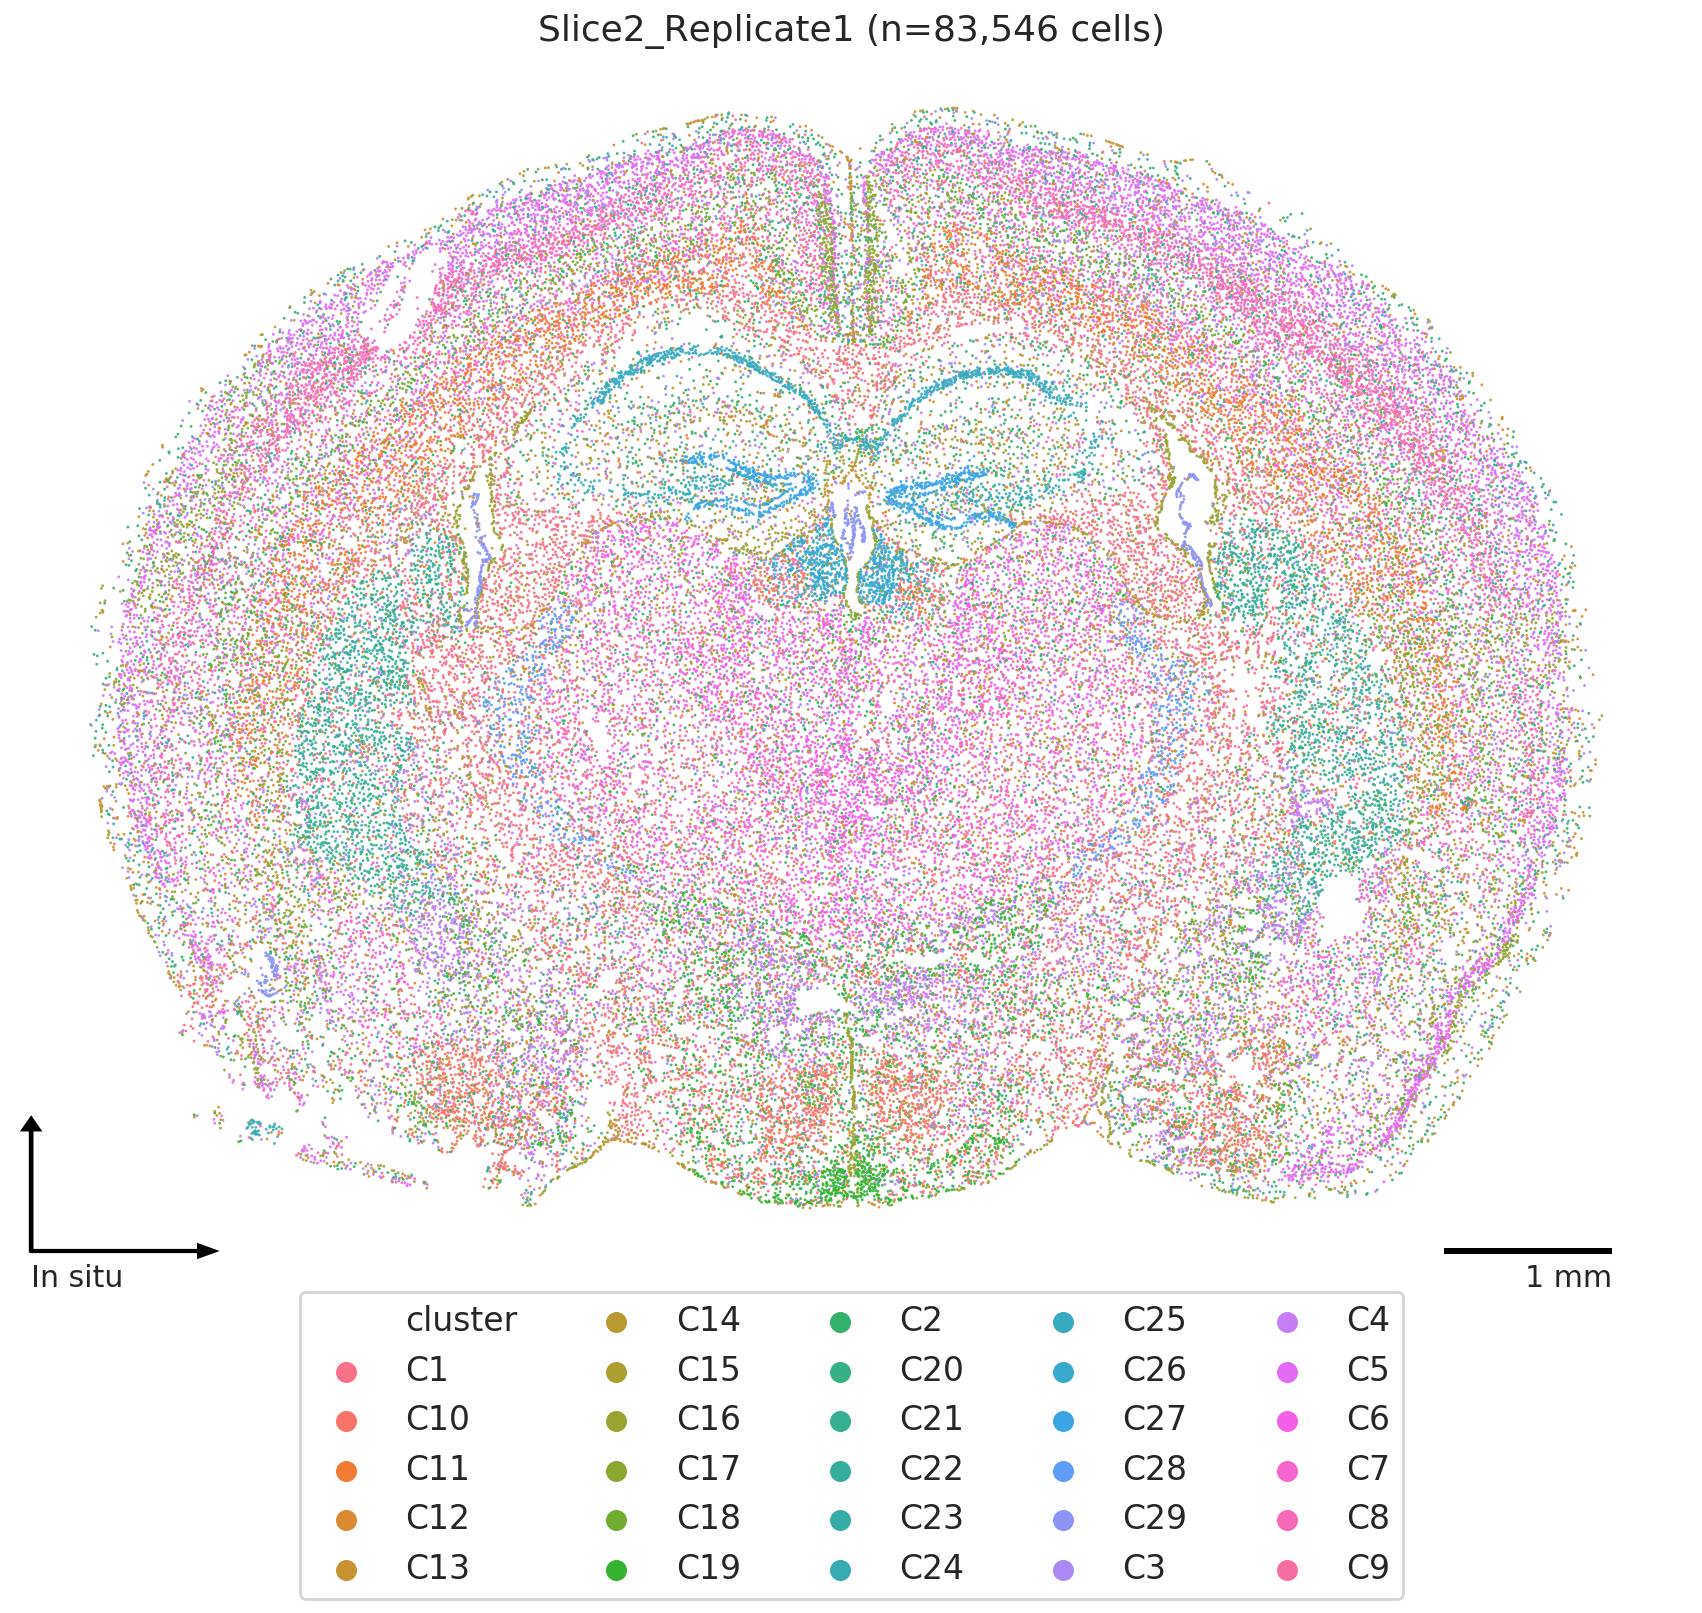

In [11]:
output1 = figures.format('in_situ_by_clusters_{}.pdf'.format(sample))
output2 = figures.format('in_situ_by_clusters_{}.png'.format(sample))

x, y, hue = 'x', 'y', 'cluster'
toplot = thedata
title = '{} (n={:,} cells)'.format(sample, len(toplot))
legend = 'full'
palette = palette_clsts
figsize = (15, 12)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
plot_spatial_routine(ax, x, y, hue, toplot, palette, legend=legend, title=title, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.5,-0.01), loc='upper center', ncol=5)

for output in [output1, output2]:
    print(output)
    snmcseq_utils.savefig(fig, output)
    
plt.show()

../figures/2021-07-09_umap_by_clusters_Slice2_Replicate1.pdf
../figures/2021-07-09_umap_by_clusters_Slice2_Replicate1.png


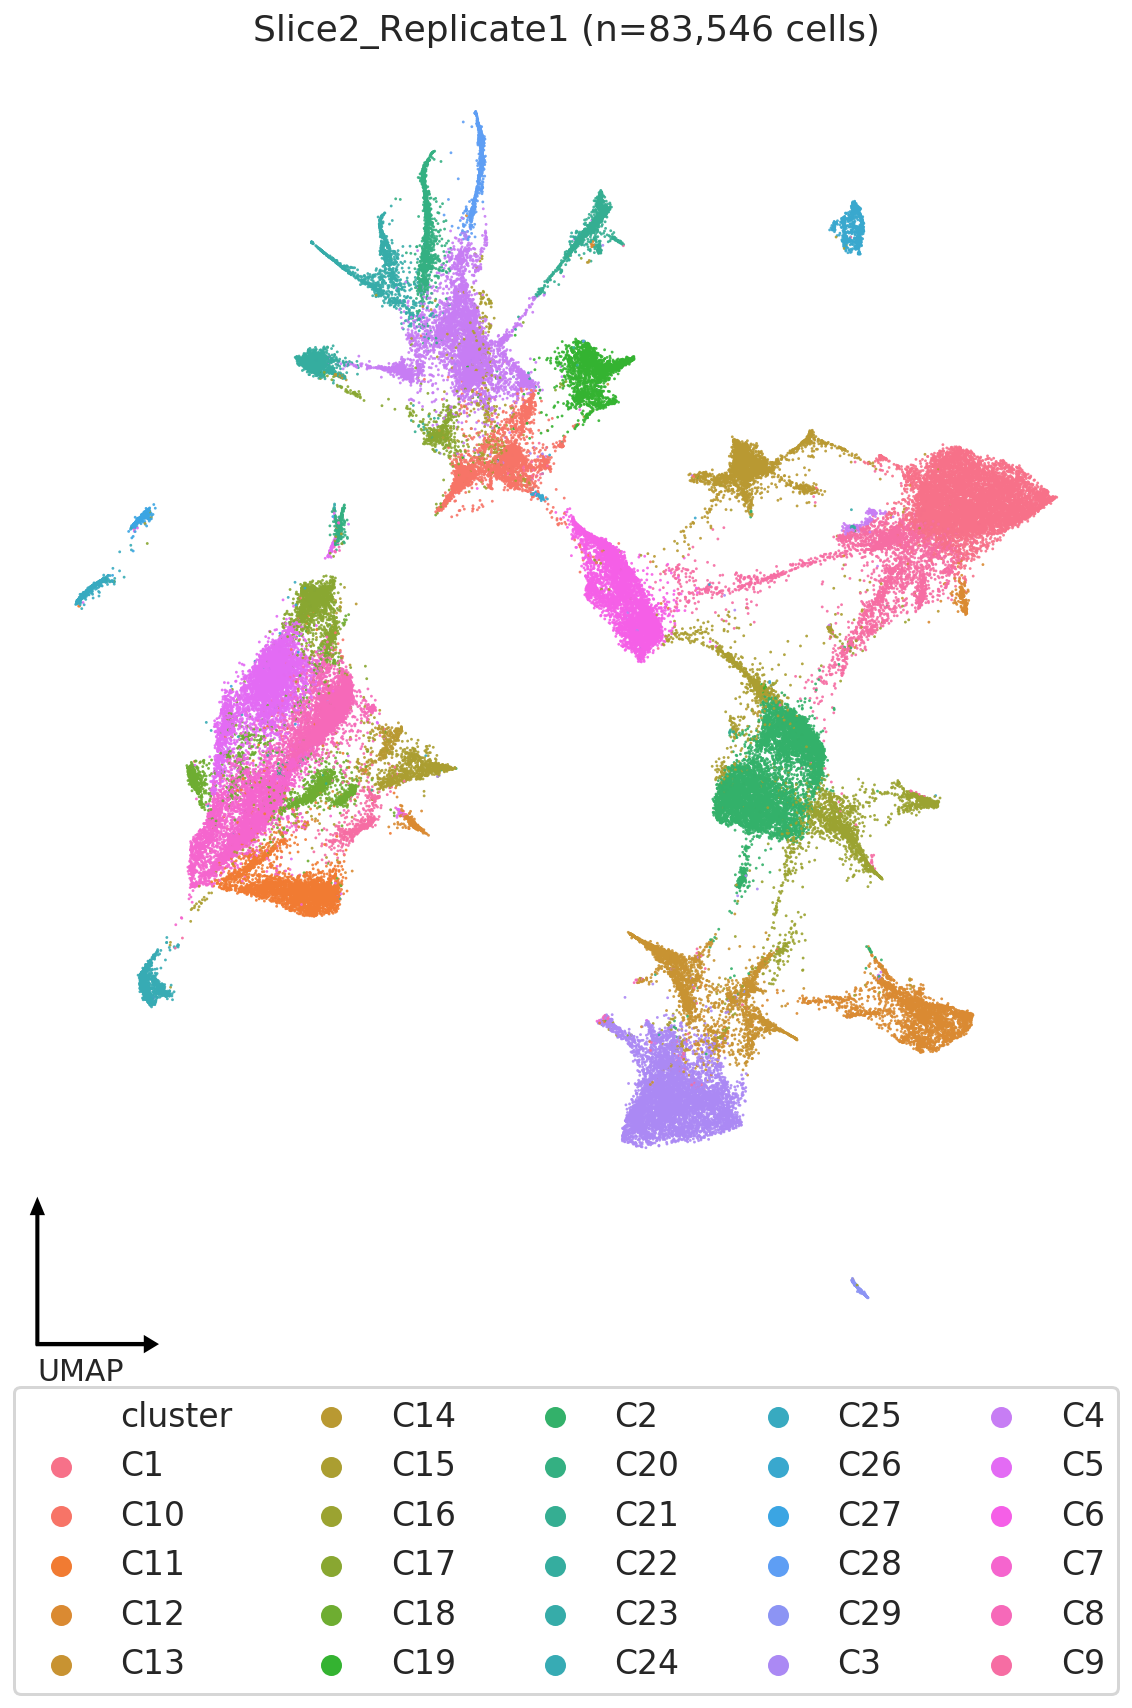

In [12]:
output1 = figures.format('umap_by_clusters_{}.pdf'.format(sample))
output2 = figures.format('umap_by_clusters_{}.png'.format(sample))

x, y, hue = 'umap_1', 'umap_2', 'cluster'
toplot = thedata
title = '{} (n={:,} cells)'.format(sample, len(toplot))
legend = 'full'
palette = palette_clsts
figsize = (10, 12)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
plot_umap_routine(ax, x, y, hue, toplot, palette, legend=legend, title=title, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.5,-0.01), loc='upper center', ncol=5)

for output in [output1, output2]:
    print(output)
    snmcseq_utils.savefig(fig, output)
plt.show()

## visualize each cluster (downsample)

In [13]:
# subsamp

nsample = 20000
toplot_subsamp = thedata.sample(n=nsample)

print(toplot_subsamp.shape)
toplot_subsamp.head()

(20000, 16)


cluster    umap_1    umap_2  \
cell                                                                  
34924819433607442969585981244246608892       C1  7.532778  2.640529   
286530885111159687632929747260141652016     C23 -3.944952  7.565330   
16235919265153662223748951986462595358      C18 -5.858193 -2.576903   
173105928246458809301806440945364449368     C15 -2.163514  7.162937   
94756233108909521581741127905323551364       C6  1.103748  0.774682   

                                                   x            y     fov  \
cell                                                                        
34924819433607442969585981244246608892  -1902.365146   791.812040  1046.0   
286530885111159687632929747260141652016 -4518.083438   223.028868  1360.0   
16235919265153662223748951986462595358   -299.177200 -2467.404024   613.0   
173105928246458809301806440945364449368  2897.765842  1642.489152   303.0   
94756233108909521581741127905323551364   -900.055431   360.498331   870.0   

                                              volume     center_x  \
cell                                                                
34924819433607442969585981244246608892    984.201139  6978.522424   
286530885111159687632929747260141652016  1358.279636  9356.620010   
16235919265153662223748951986462595358    337.352291  4583.565317   
173105928246458809301806440945364449368   345.304223  2564.278451   
94756233108909521581741127905323551364   1985.486774  5898.570020   

                                            center_y        min_x  \
cell                                                                
34924819433607442969585981244246608892   3491.321475  6972.085624   
286530885111159687632929747260141652016  4720.202412  9349.319210   
16235919265153662223748951986462595358   6222.050572  4579.504517   
173105928246458809301806440945364449368  1422.660268  2559.191650   
94756233108909521581741127905323551364   3647.395447  5889.325220   

                                               max_x        min_y  \
cell                                                                
34924819433607442969585981244246608892   6984.959224  3482.400675   
286530885111159687632929747260141652016  9363.920810  4711.011612   
16235919265153662223748951986462595358   4587.626117  6216.207772   
173105928246458809301806440945364449368  2569.365251  1417.087468   
94756233108909521581741127905323551364   5907.814820  3636.422647   

                                               max_y  cell_cov  cell_cov_norm  \
cell                                                                            
34924819433607442969585981244246608892   3500.242275      99.0      80.304491   
286530885111159687632929747260141652016  4729.393212     200.0     117.551806   
16235919265153662223748951986462595358   6227.893372     181.0     428.334850   
173105928246458809301806440945364449368  1428.233068     137.0     316.743110   
94756233108909521581741127905323551364   3658.368247    1102.0     443.101373   

                                                    sample  
cell                                                        
34924819433607442969585981244246608892   Slice2_Replicate1  
286530885111159687632929747260141652016  Slice2_Replicate1  
16235919265153662223748951986462595358   Slice2_Replicate1  
173105928246458809301806440945364449368  Slice2_Replicate1  
94756233108909521581741127905323551364   Slice2_Replicate1

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


../figures/2021-07-09_in_situ_umap_by_clusters_Slice2_Replicate1_C16.pdf
../figures/2021-07-09_in_situ_umap_by_clusters_Slice2_Replicate1_C16.png


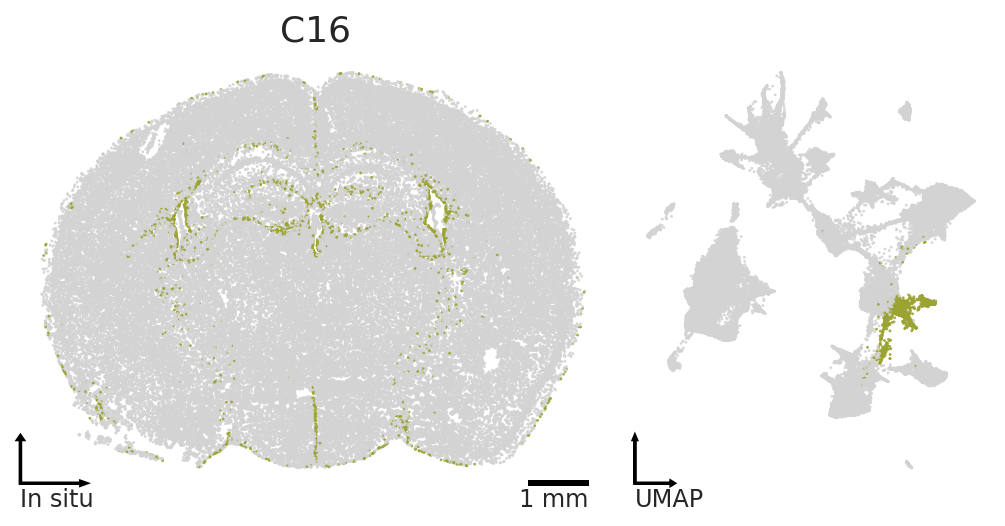

In [14]:
x_spatial, y_spatial = 'x', 'y'
x_umap, y_umap = 'umap_1', 'umap_2'
hue = 'cluster'
legend = False
fontsize = 12

# n = len(uniq_clsts)
for i, clst in enumerate(uniq_clsts):
    if clst == 'C16':
        output1 = figures.format('in_situ_umap_by_clusters_{}_{}.pdf'.format(sample, clst))
        output2 = figures.format('in_situ_umap_by_clusters_{}_{}.png'.format(sample, clst))

        fig, axs_row = plt.subplots(1, 2, figsize=(5*2,4*1))
        title = '{}'.format(clst)
        palette_specific = {_clst: palette_clsts[_clst] if _clst == clst else "lightgray" 
                            for _clst in uniq_clsts} 
        ax = axs_row[0]
        plot_spatial_routine(
            ax, x_spatial, y_spatial, hue, toplot, 
            palette_specific, legend=legend, title=title, fontsize=fontsize,
        )
        ax = axs_row[1]
        plot_umap_routine(
            ax, x_umap, y_umap, hue, toplot, 
            palette_specific, legend=legend, title='', fontsize=fontsize,
        )
        fig.subplots_adjust(wspace=-0.2)

        for output in [output1, output2]:
            print(output)
            snmcseq_utils.savefig(fig, output)
        plt.show()

# Gene by cluster heatmap 

In [15]:
import colorcet

In [16]:
# # selecteddata
selecteddata = thedatagmat

# mean, std, n, zscore 
gmat_mean = selecteddata.groupby(['cluster']).mean()[genes]
gmat_std = selecteddata.groupby(['cluster']).std()[genes]
gmat_n = selecteddata.groupby(['cluster']).count()[genes]
gmat_meanz = (gmat_mean - gmat_mean.mean())/gmat_mean.std()

# celltypes
# celltypes = gmat_mean.index.levels[0].values
celltypes = gmat_mean.index.values

print(selecteddata.shape)
print(gmat_mean.shape, gmat_std.shape, gmat_n.shape, gmat_meanz.shape)

(83546, 499)
(29, 483) (29, 483) (29, 483) (29, 483)


../figures/2021-07-09_gene_by_clusters_separate_samples.pdf


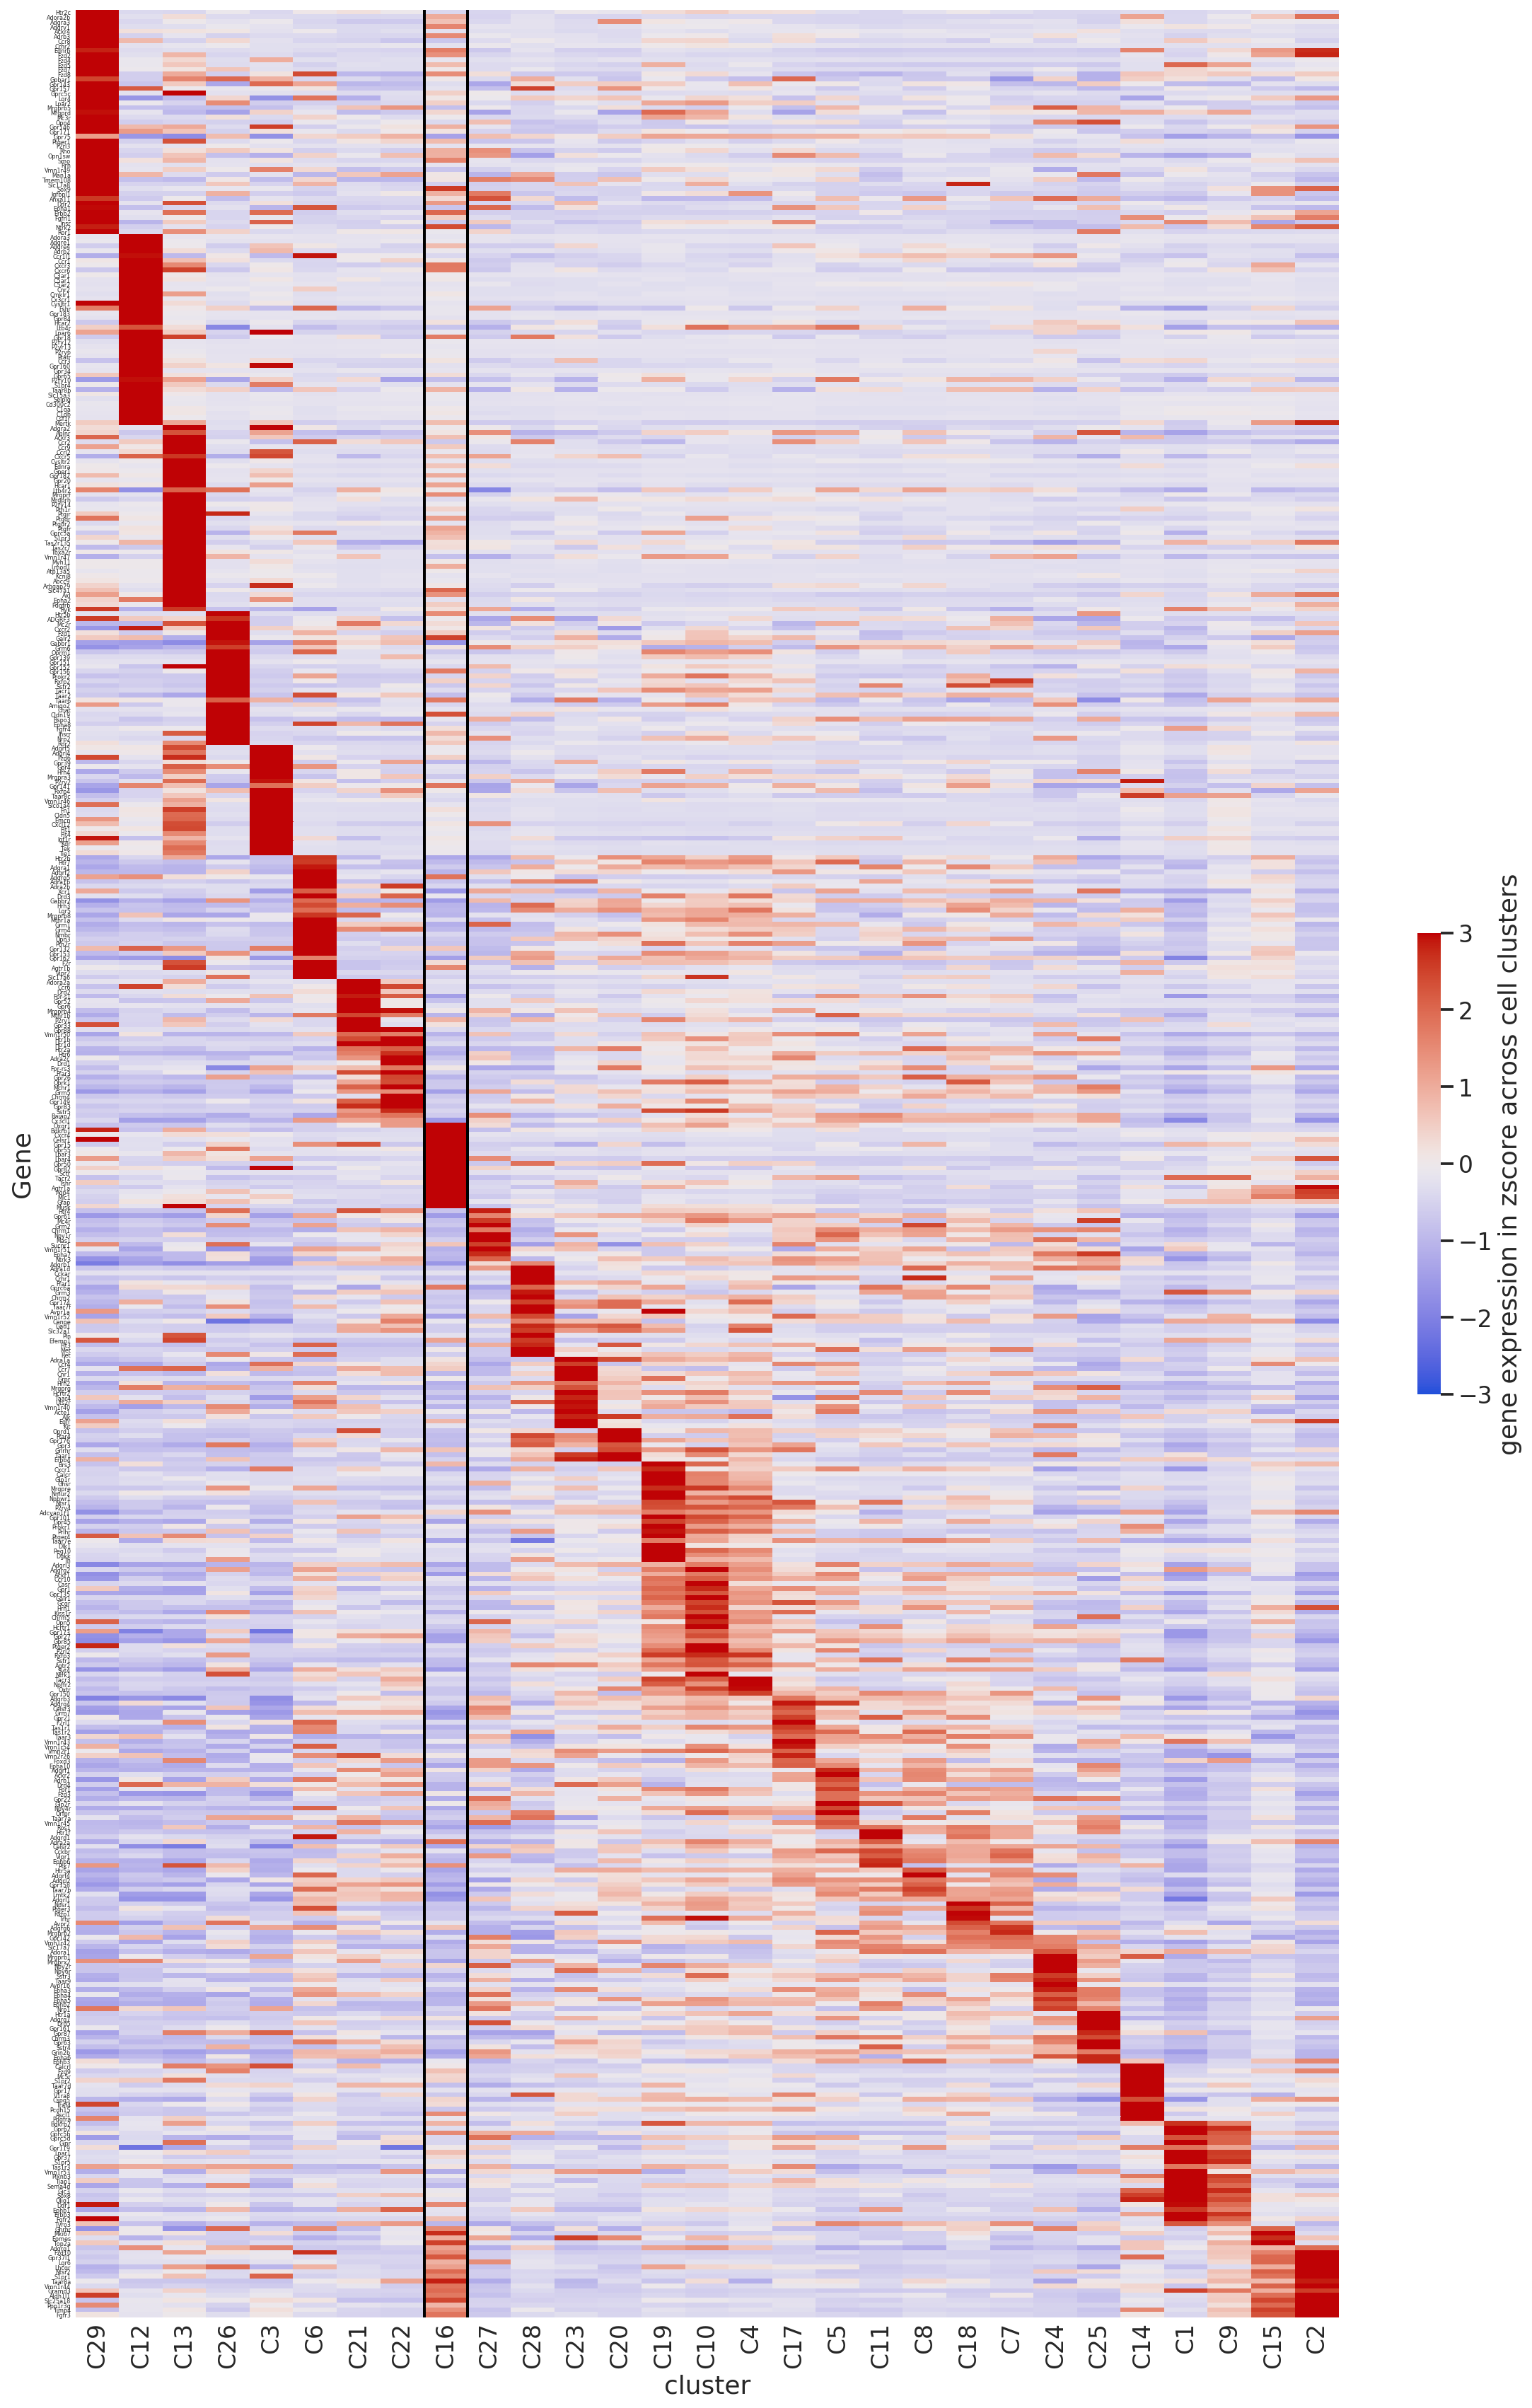

In [17]:
output = figures.format("gene_by_clusters_separate_samples.pdf")

heatmat = gmat_meanz.T

nrow, ncol = heatmat.shape

# # order1 
# _, rowidx, colidx_reduced = utils.diag_matrix(heatmat.values, threshold=1)
# colidx = np.hstack([4*col+np.array([0,1,2,3]) for col in colidx_reduced])

# order2
row_order = utils.get_order_from_hierarchy(heatmat)
col_order_reduced = utils.get_order_from_hierarchy(heatmat.T) # by cluster; collapse slices
col_order = col_order_reduced #np.hstack([4*col+np.array([0,1,2,3]) for col in col_order_reduced])

# order3 (curated col_order_reduced)
_, rowidx_v3, _ = utils.diag_matrix_rows(heatmat.iloc[:,col_order_reduced].values)


fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(
#     heatmat.iloc[row_order, col_order], 
#     heatmat.iloc[rowidx, colidx], 
    heatmat.iloc[rowidx_v3, col_order], 
    vmax=3, vmin=-3, center=0, 
    xticklabels=True,
    yticklabels=True,
    cmap=colorcet.coolwarm,
    ax=ax,
    cbar_kws=dict(shrink=0.2, label='gene expression in zscore across cell clusters'),
   )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_ylabel('Gene')

# xtl = [tl.get_text() for tl in ax.get_xticklabels()]
# xtl_part1 = [tl.split('-')[0] for tl in xtl]
# xtl_part2 = ['-'.join(tl.split('-')[1:]) for tl in xtl]
# xtl_simp = list(snmcseq_utils.dedup_array_elements(xtl_part1))
# ax.set_xticklabels(xtl_simp)
# for i in range(4): 
#     ax.annotate(xtl_part2[i], 
#                 (i+0.5, 0), (2*i, -2), 
#                 arrowprops=dict(arrowstyle='-', color='black'), 
#                 va='bottom', 
#                 ha='center',
#                 rotation=90,
#                )

# ax.vlines(np.arange(0, ncol, 4)[1:], 0, nrow, color='black', linewidth=1, clip_on=False)
# ax.vlines(np.arange(2, ncol, 4), 0, nrow, color='gray', linewidth=0.5, clip_on=False)
ax.vlines([8,9], 0, nrow, color='black', linewidth=2, clip_on=False)

utils.savefig(fig, output)
print(output)
plt.show()

cluster_orders = col_order_reduced

In [18]:
heatmat_viz = heatmat.iloc[rowidx_v3, col_order]

In [19]:
heatmat_viz.to_csv(
    '../data/S2R1_gene_cluster_zscores.tsv', 
    sep='\t', header=True, index=True)

gmat_mean.T.loc[heatmat_viz.index, heatmat_viz.columns].to_csv(
    '../data/S2R1_gene_cluster_lognormcounts.tsv', 
    sep='\t', header=True, index=True)

In [20]:
heatmat_viz['C16']

Htr2c      -0.409215
Adora2b     1.022419
Adgra3      0.681997
Adgrv1      1.571785
Ackr4      -0.238577
              ...   
Aldh1l1     1.778781
Slc25a18    2.447631
Ppp1r3g     0.858928
Timp4       1.443002
Fgfr3       1.824918
Name: C16, Length: 483, dtype: float64

In [21]:
(np.power(10, gmat)-1).sum(axis=1)

149164679103246548309819743981609972453    257.118765
237155298815097057940587033798543926454    257.118765
117749472799775376881672023779789020086    257.118765
15016935204501029374284305801070750441     257.118765
167702564287808924695032218174386816671    257.118765
                                              ...    
296809147219581569628143171264459652264    257.118765
319511391673461599096199153809568080195    257.118765
321308844942453237595536241855120823226    257.118765
84532889385686279418999832003470494748     257.118765
188654480509734336181238235687866285740    257.118765
Length: 79420, dtype: float64

# gene-gene correlation
- 

In [57]:
gmat
# gmat.T
rgmat = gmat.rank(axis=1, pct=True)

In [61]:
ggcorr = np.corrcoef(rgmat.T.values)
ggcorr = pd.DataFrame(ggcorr, index=genes, columns=genes)
Z = sch.linkage(ggcorr, optimal_ordering=True, method='average')
d = sch.dendrogram(Z, no_plot=True,)
print(ggcorr.shape)
ggcorr

(483, 483)


Oxgr1     Htr1a     Htr1b     Htr1d     Htr1f     Htr2a     Htr2b  \
Oxgr1  1.000000 -0.018587 -0.014140  0.058524 -0.050665 -0.037923  0.179375   
Htr1a -0.018587  1.000000  0.063810 -0.033739  0.090530  0.087074 -0.081330   
Htr1b -0.014140  0.063810  1.000000  0.152425  0.053250  0.132900 -0.137561   
Htr1d  0.058524 -0.033739  0.152425  1.000000 -0.032077  0.041534  0.128547   
Htr1f -0.050665  0.090530  0.053250 -0.032077  1.000000  0.154946 -0.144753   
...         ...       ...       ...       ...       ...       ...       ...   
Ros1   0.151588 -0.066378 -0.118379  0.104421 -0.111117 -0.102091  0.469504   
Ryk   -0.061161  0.003598  0.028623 -0.063890  0.035016  0.027465 -0.209569   
Tek    0.050866 -0.074016 -0.100977  0.017899 -0.113001 -0.075749  0.200671   
Tie1   0.043511 -0.061694 -0.085987  0.012265 -0.093481 -0.064088  0.178237   
Tyro3 -0.060348  0.073175  0.083414 -0.012934  0.186746  0.124395 -0.191127   

          Htr2c      Htr4     Htr5a  ...    Pdgfrb      Ptk7       Ret  \
Oxgr1 -0.040981 -0.014624 -0.086496  ...  0.024641 -0.036362 -0.045259   
Htr1a  0.009178  0.015015  0.098010  ... -0.086013 -0.013886 -0.067558   
Htr1b  0.134382  0.202559  0.072199  ... -0.108859  0.008182 -0.037106   
Htr1d  0.073812  0.118984 -0.090686  ... -0.007737 -0.011003 -0.044741   
Htr1f -0.034949  0.009307  0.158624  ... -0.133845  0.100626 -0.088495   
...         ...       ...       ...  ...       ...       ...       ...   
Ros1  -0.112117 -0.101607 -0.223382  ...  0.109124 -0.116013 -0.056610   
Ryk   -0.006183  0.017031  0.077471  ...  0.017601  0.074841 -0.029446   
Tek   -0.101969 -0.100443 -0.177233  ...  0.193269 -0.079126  0.034071   
Tie1  -0.085333 -0.093177 -0.151703  ...  0.161320 -0.067204  0.027112   
Tyro3  0.007089 -0.007326  0.170599  ... -0.242932  0.044866 -0.131926   

           Ror1      Ror2      Ros1       Ryk       Tek      Tie1     Tyro3  
Oxgr1  0.033117  0.054220  0.151588 -0.061161  0.050866  0.043511 -0.060348  
Htr1a -0.015145 -0.019031 -0.066378  0.003598 -0.074016 -0.061694  0.073175  
Htr1b  0.039465 -0.075452 -0.118379  0.028623 -0.100977 -0.085987  0.083414  
Htr1d  0.081228  0.025459  0.104421 -0.063890  0.017899  0.012265 -0.012934  
Htr1f -0.053986 -0.082311 -0.111117  0.035016 -0.113001 -0.093481  0.186746  
...         ...       ...       ...       ...       ...       ...       ...  
Ros1   0.088236  0.141687  1.000000 -0.172282  0.173678  0.156167 -0.153327  
Ryk   -0.009246 -0.058526 -0.172282  1.000000 -0.096184 -0.088348  0.132162  
Tek    0.099004  0.082074  0.173678 -0.096184  1.000000  0.604351 -0.258201  
Tie1   0.087162  0.074198  0.156167 -0.088348  0.604351  1.000000 -0.223614  
Tyro3 -0.107288 -0.141098 -0.153327  0.132162 -0.258201 -0.223614  1.000000  

[483 rows x 483 columns]

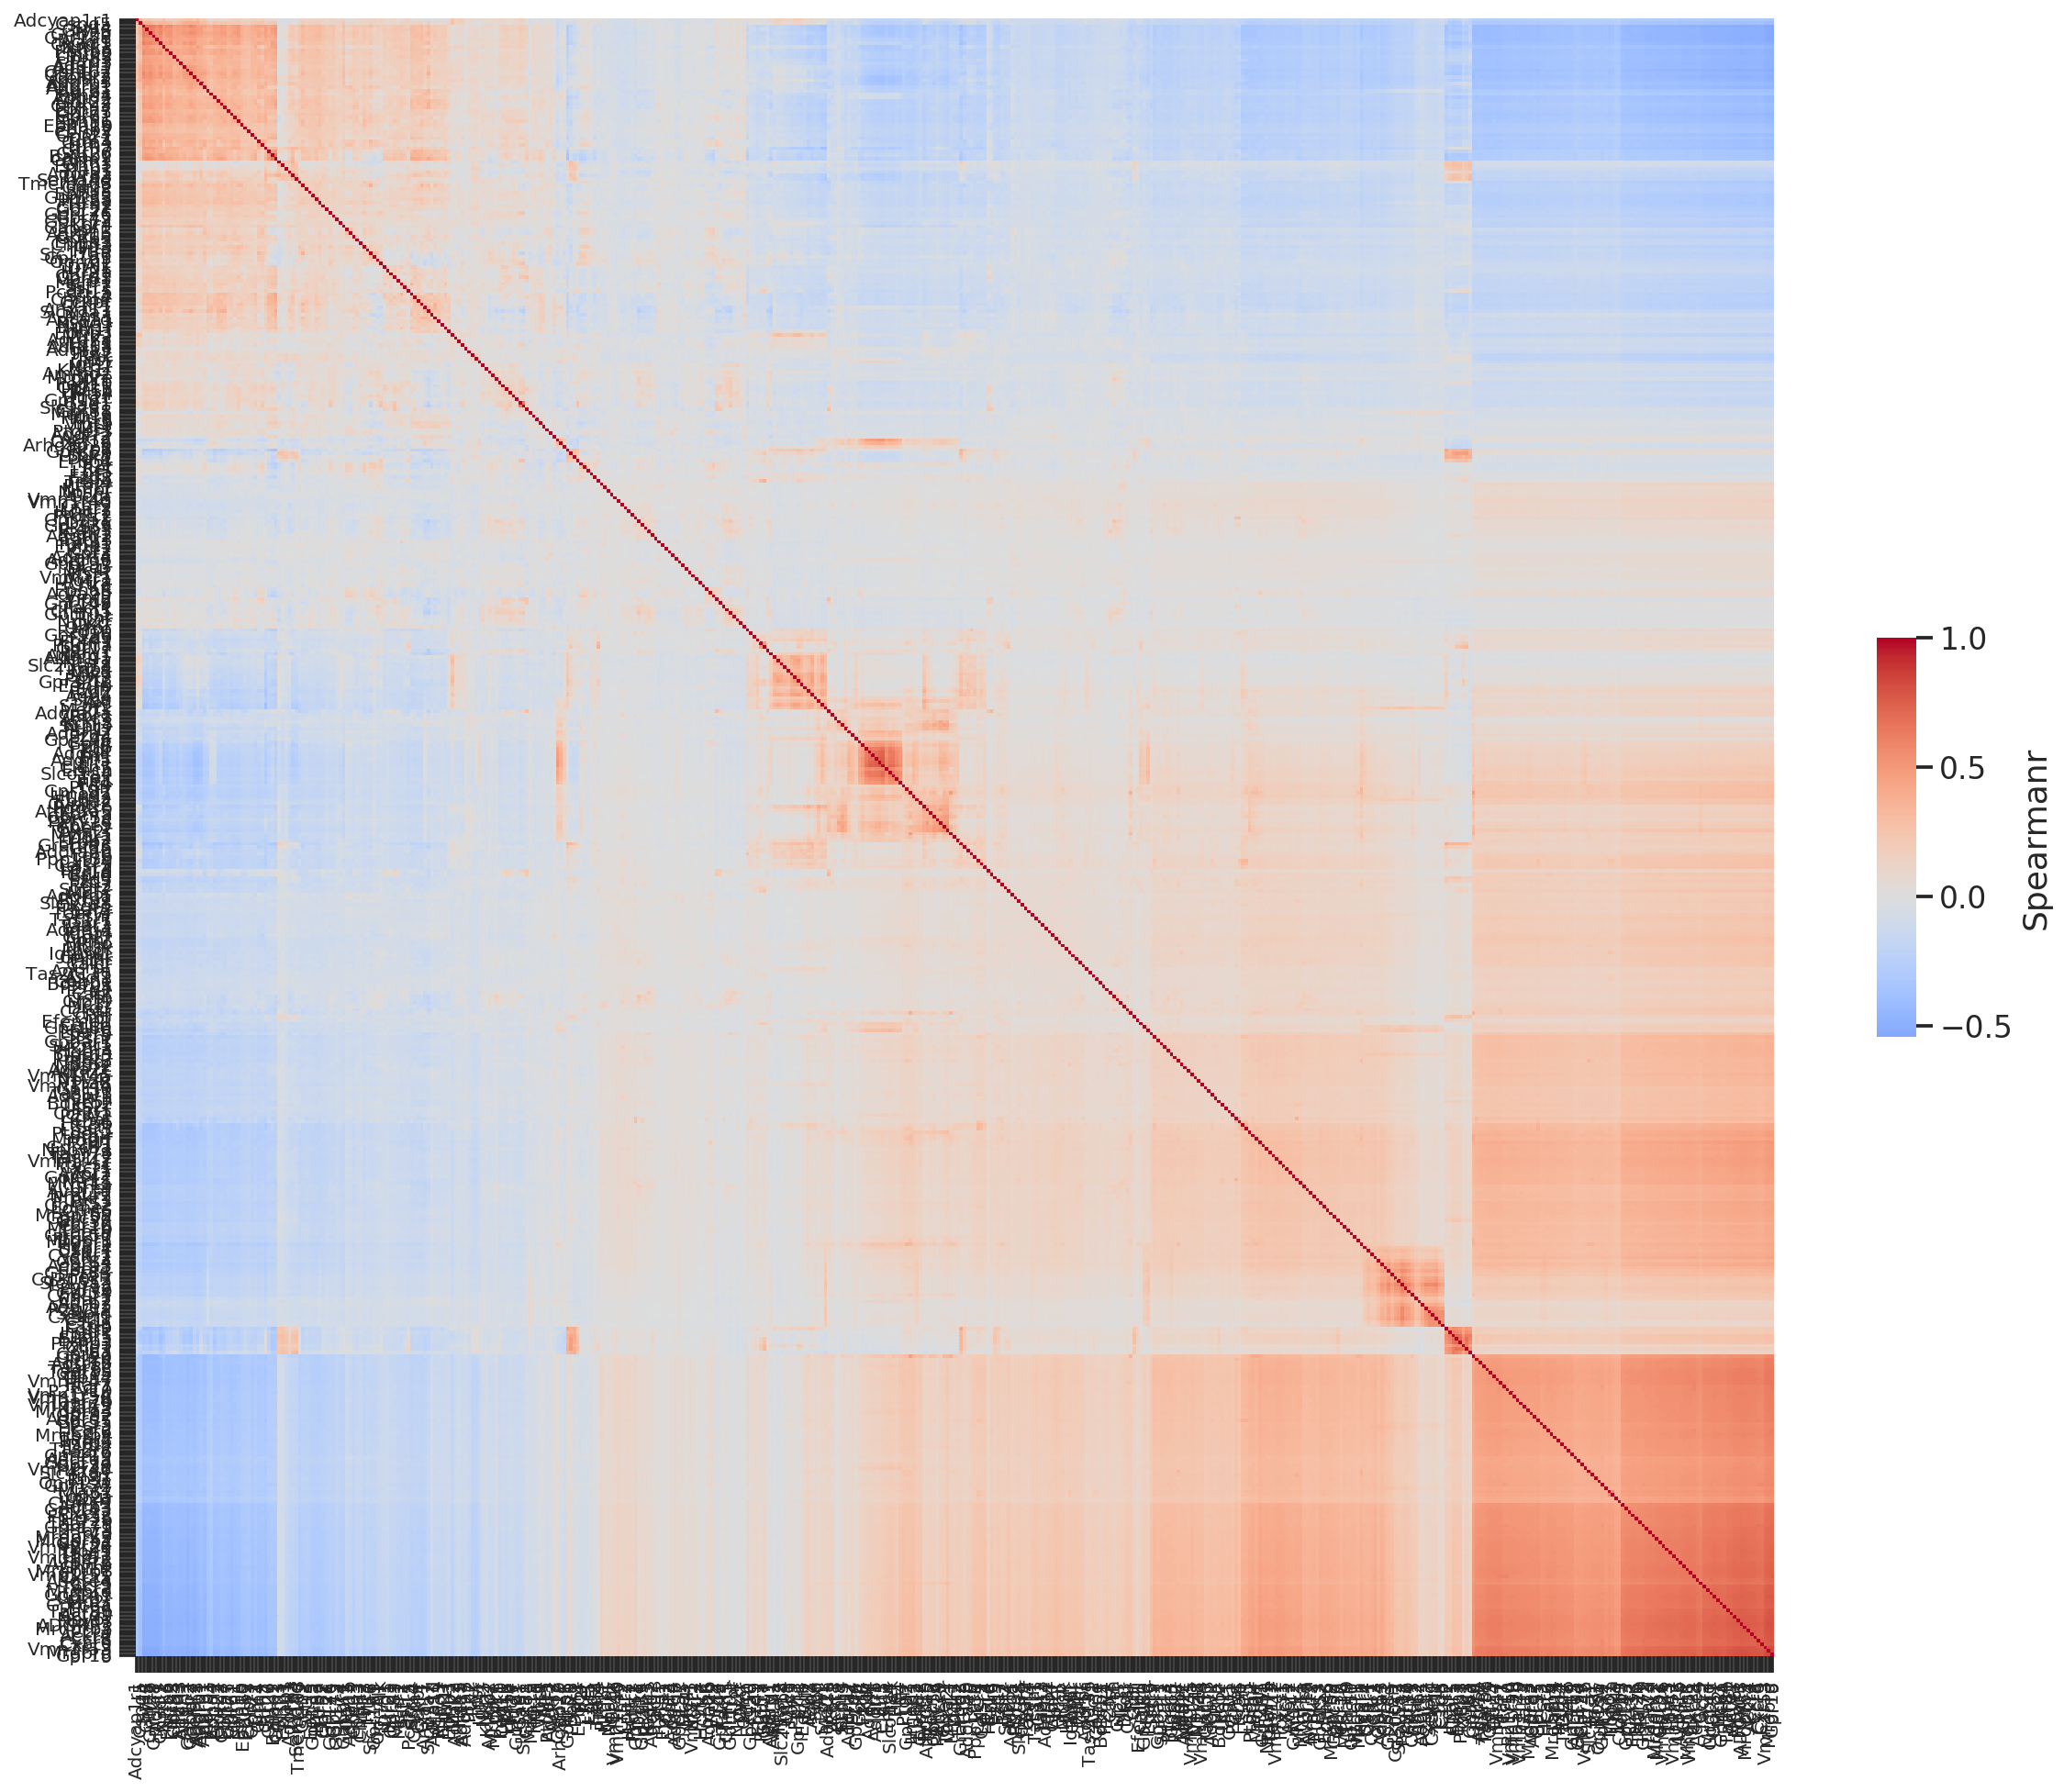

In [62]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ggcorr.iloc[d['leaves'], d['leaves']], 
            xticklabels=True,
            yticklabels=True,
            cbar_kws=dict(label='Spearmanr', aspect=10, shrink=0.2),
            cmap='coolwarm',
            center=0,
            ax=ax)
ax.set_aspect('equal')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.show()


In [63]:
ggcorr = np.corrcoef(gmat.T.values)
ggcorr = pd.DataFrame(ggcorr, index=genes, columns=genes)
Z = sch.linkage(ggcorr, optimal_ordering=True, method='average')
d = sch.dendrogram(Z, no_plot=True,)
print(ggcorr.shape)
ggcorr

(483, 483)


Oxgr1     Htr1a     Htr1b     Htr1d     Htr1f     Htr2a     Htr2b  \
Oxgr1  1.000000  0.019239  0.033834  0.015620 -0.000951  0.005023 -0.002790   
Htr1a  0.019239  1.000000  0.085598  0.017645  0.084902  0.082881  0.000909   
Htr1b  0.033834  0.085598  1.000000  0.192756  0.056974  0.132858  0.003445   
Htr1d  0.015620  0.017645  0.192756  1.000000  0.019672  0.073407  0.006438   
Htr1f -0.000951  0.084902  0.056974  0.019672  1.000000  0.135094  0.001224   
...         ...       ...       ...       ...       ...       ...       ...   
Ros1   0.002364  0.003097 -0.001041 -0.003402  0.008522  0.006556 -0.000868   
Ryk    0.011617 -0.022830 -0.007007 -0.011749 -0.031587 -0.029873  0.001225   
Tek   -0.019516 -0.066963 -0.077247 -0.041561 -0.093879 -0.051877 -0.007124   
Tie1  -0.019539 -0.060599 -0.068392 -0.038087 -0.083526 -0.044112 -0.007435   
Tyro3 -0.004500  0.027992  0.032534  0.029841  0.125556  0.071772 -0.004951   

          Htr2c      Htr4     Htr5a  ...    Pdgfrb      Ptk7       Ret  \
Oxgr1  0.009897  0.027171  0.015300  ... -0.019967  0.030866 -0.005842   
Htr1a  0.044390  0.043853  0.101632  ... -0.071010 -0.000227 -0.013210   
Htr1b  0.111025  0.208656  0.084202  ... -0.075579  0.013772  0.003196   
Htr1d  0.072452  0.138427  0.017817  ... -0.043219  0.029685 -0.005557   
Htr1f -0.008798  0.027075  0.131319  ... -0.100659  0.102958 -0.033791   
...         ...       ...       ...  ...       ...       ...       ...   
Ros1   0.000388  0.000595  0.012835  ...  0.000116  0.013089  0.001027   
Ryk   -0.005295 -0.012262 -0.027488  ...  0.123139  0.033338 -0.055880   
Tek   -0.081250 -0.085585 -0.120728  ...  0.150446 -0.054048  0.032296   
Tie1  -0.064350 -0.078796 -0.106474  ...  0.123671 -0.046823  0.035578   
Tyro3 -0.033526 -0.040908  0.081029  ... -0.220298 -0.018477 -0.148077   

           Ror1      Ror2      Ros1       Ryk       Tek      Tie1     Tyro3  
Oxgr1 -0.004114  0.000115  0.002364  0.011617 -0.019516 -0.019539 -0.004500  
Htr1a  0.012840  0.023173  0.003097 -0.022830 -0.066963 -0.060599  0.027992  
Htr1b  0.047675 -0.016514 -0.001041 -0.007007 -0.077247 -0.068392  0.032534  
Htr1d  0.025410 -0.010831 -0.003402 -0.011749 -0.041561 -0.038087  0.029841  
Htr1f -0.023657 -0.024918  0.008522 -0.031587 -0.093879 -0.083526  0.125556  
...         ...       ...       ...       ...       ...       ...       ...  
Ros1  -0.000620 -0.003928  1.000000  0.002606  0.002826  0.006652  0.005177  
Ryk    0.054844  0.020129  0.002606  1.000000 -0.029677 -0.031215  0.085524  
Tek    0.039690  0.008547  0.002826 -0.029677  1.000000  0.646359 -0.221434  
Tie1   0.040785  0.012399  0.006652 -0.031215  0.646359  1.000000 -0.200658  
Tyro3 -0.081747 -0.089627  0.005177  0.085524 -0.221434 -0.200658  1.000000  

[483 rows x 483 columns]

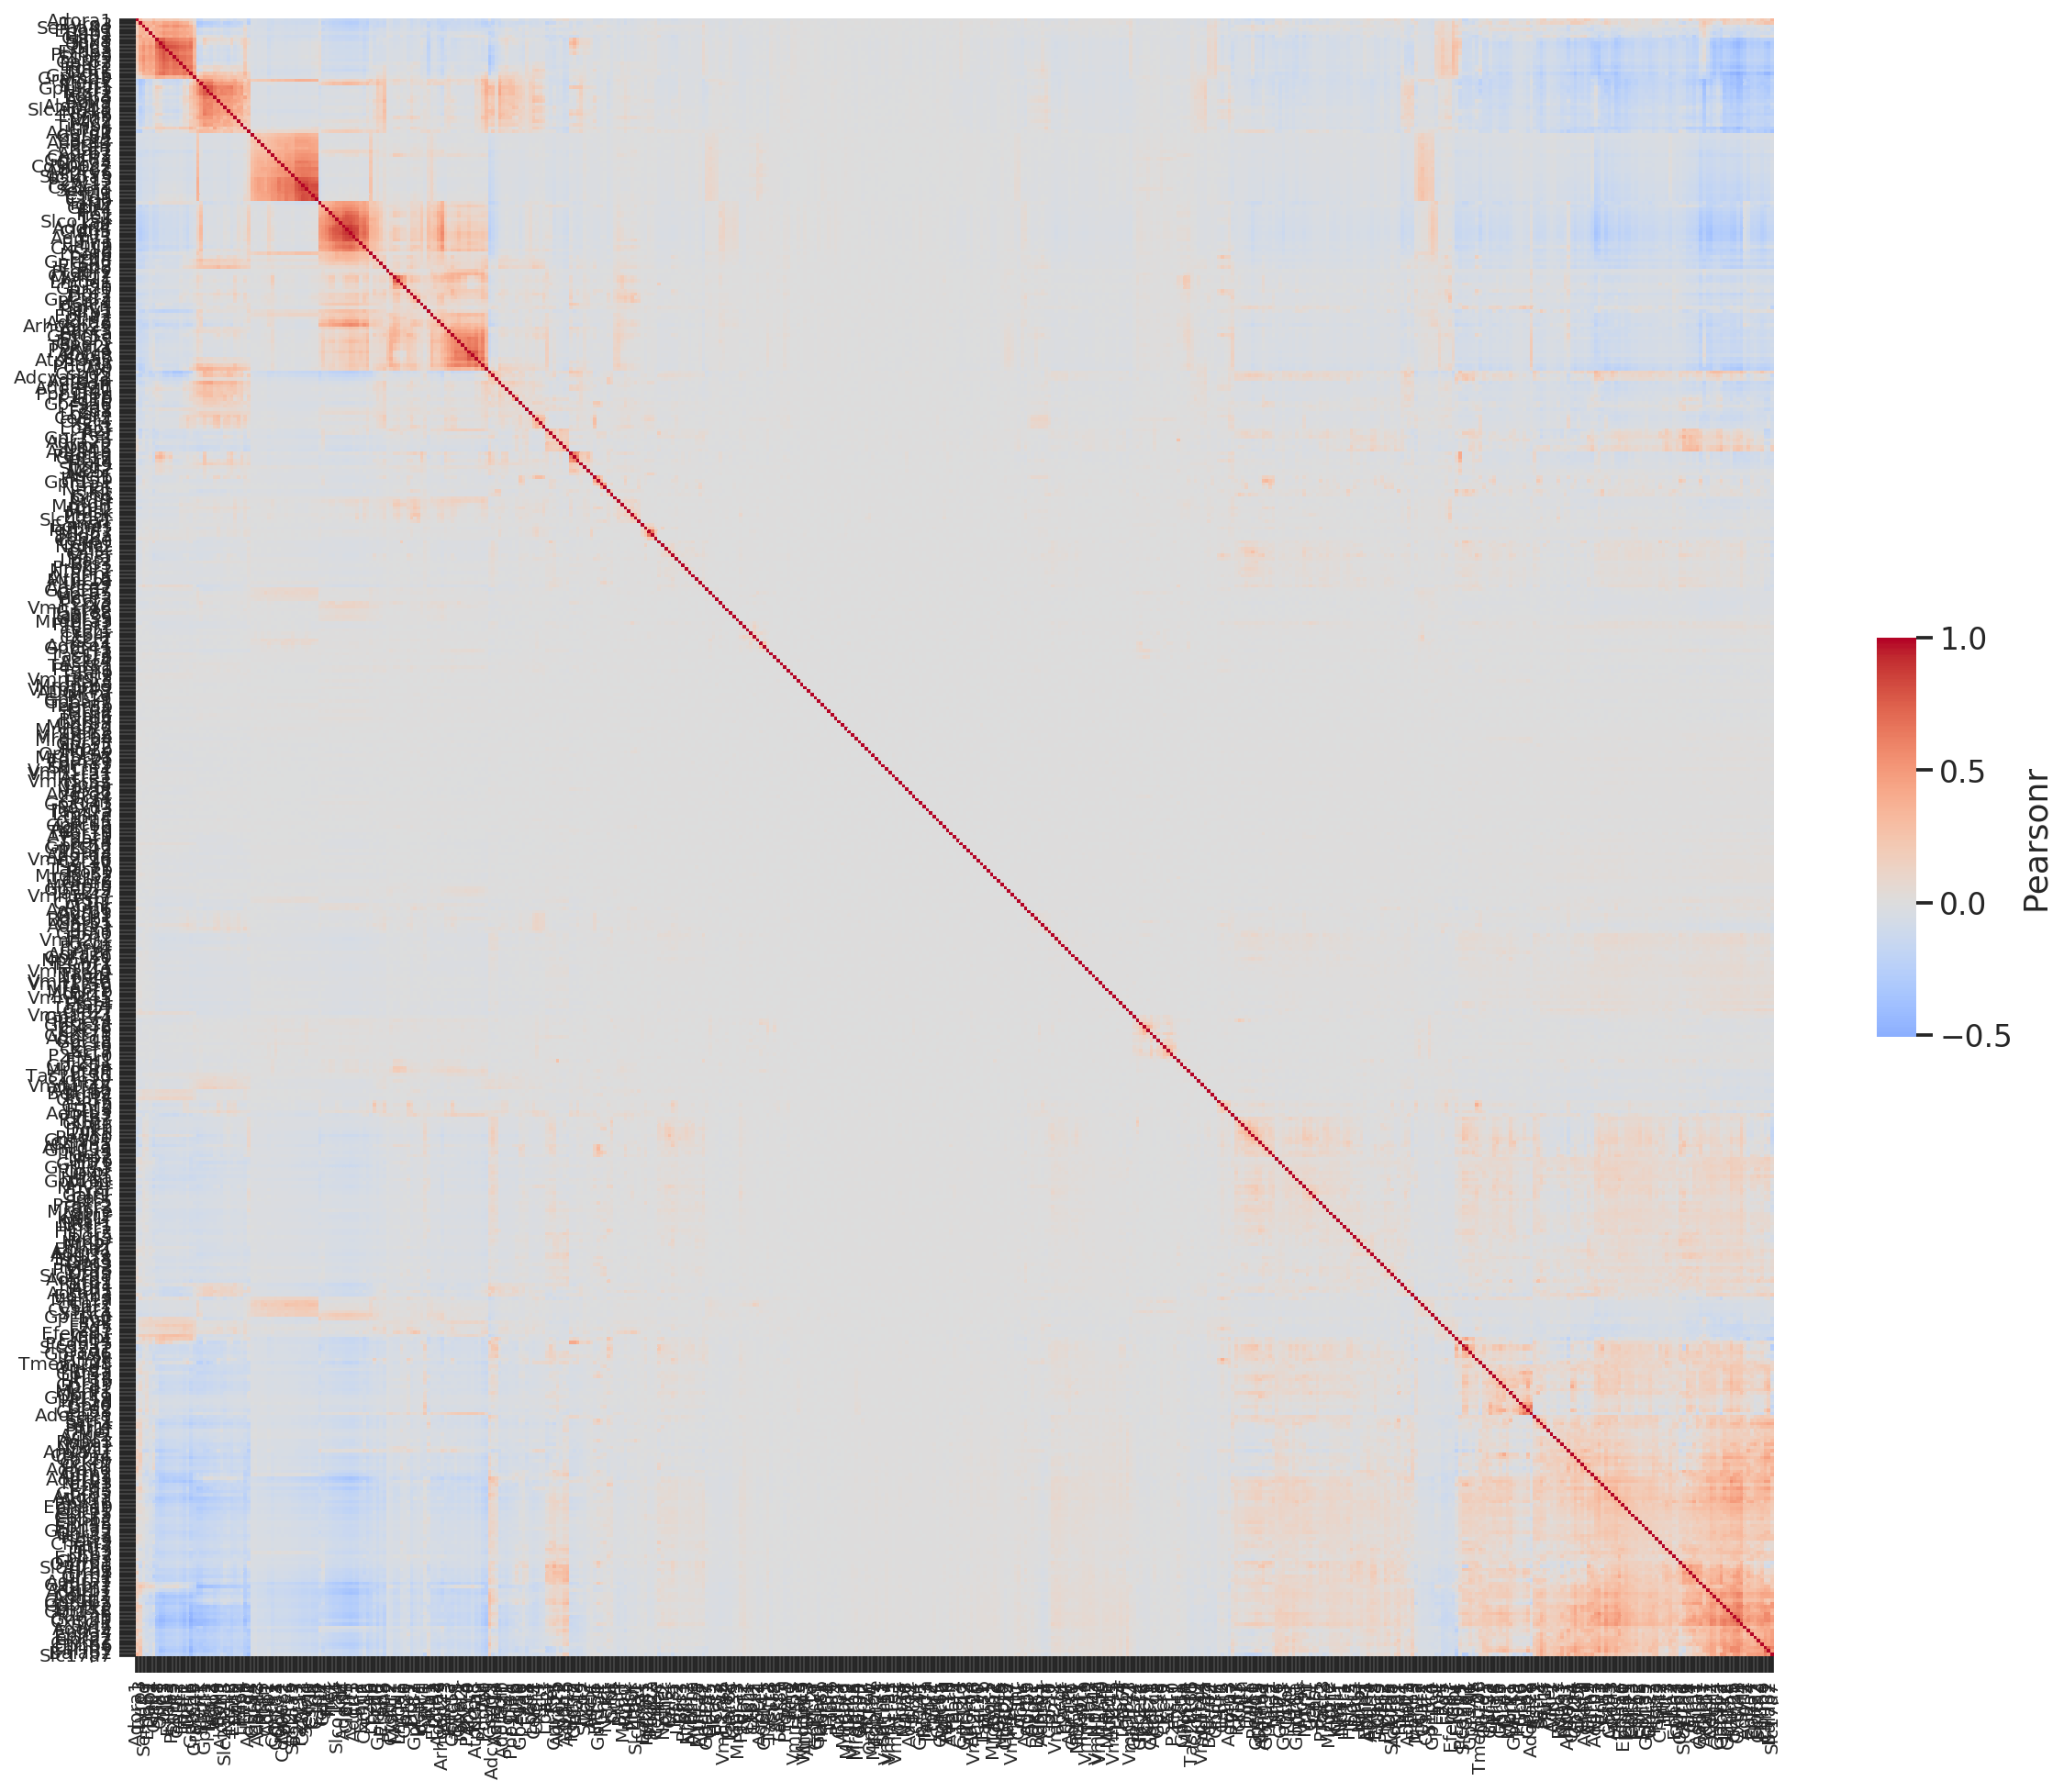

In [64]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ggcorr.iloc[d['leaves'], d['leaves']], 
            xticklabels=True,
            yticklabels=True,
            cbar_kws=dict(label='Pearsonr', aspect=10, shrink=0.2),
            cmap='coolwarm',
            center=0,
            ax=ax)
ax.set_aspect('equal')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.show()


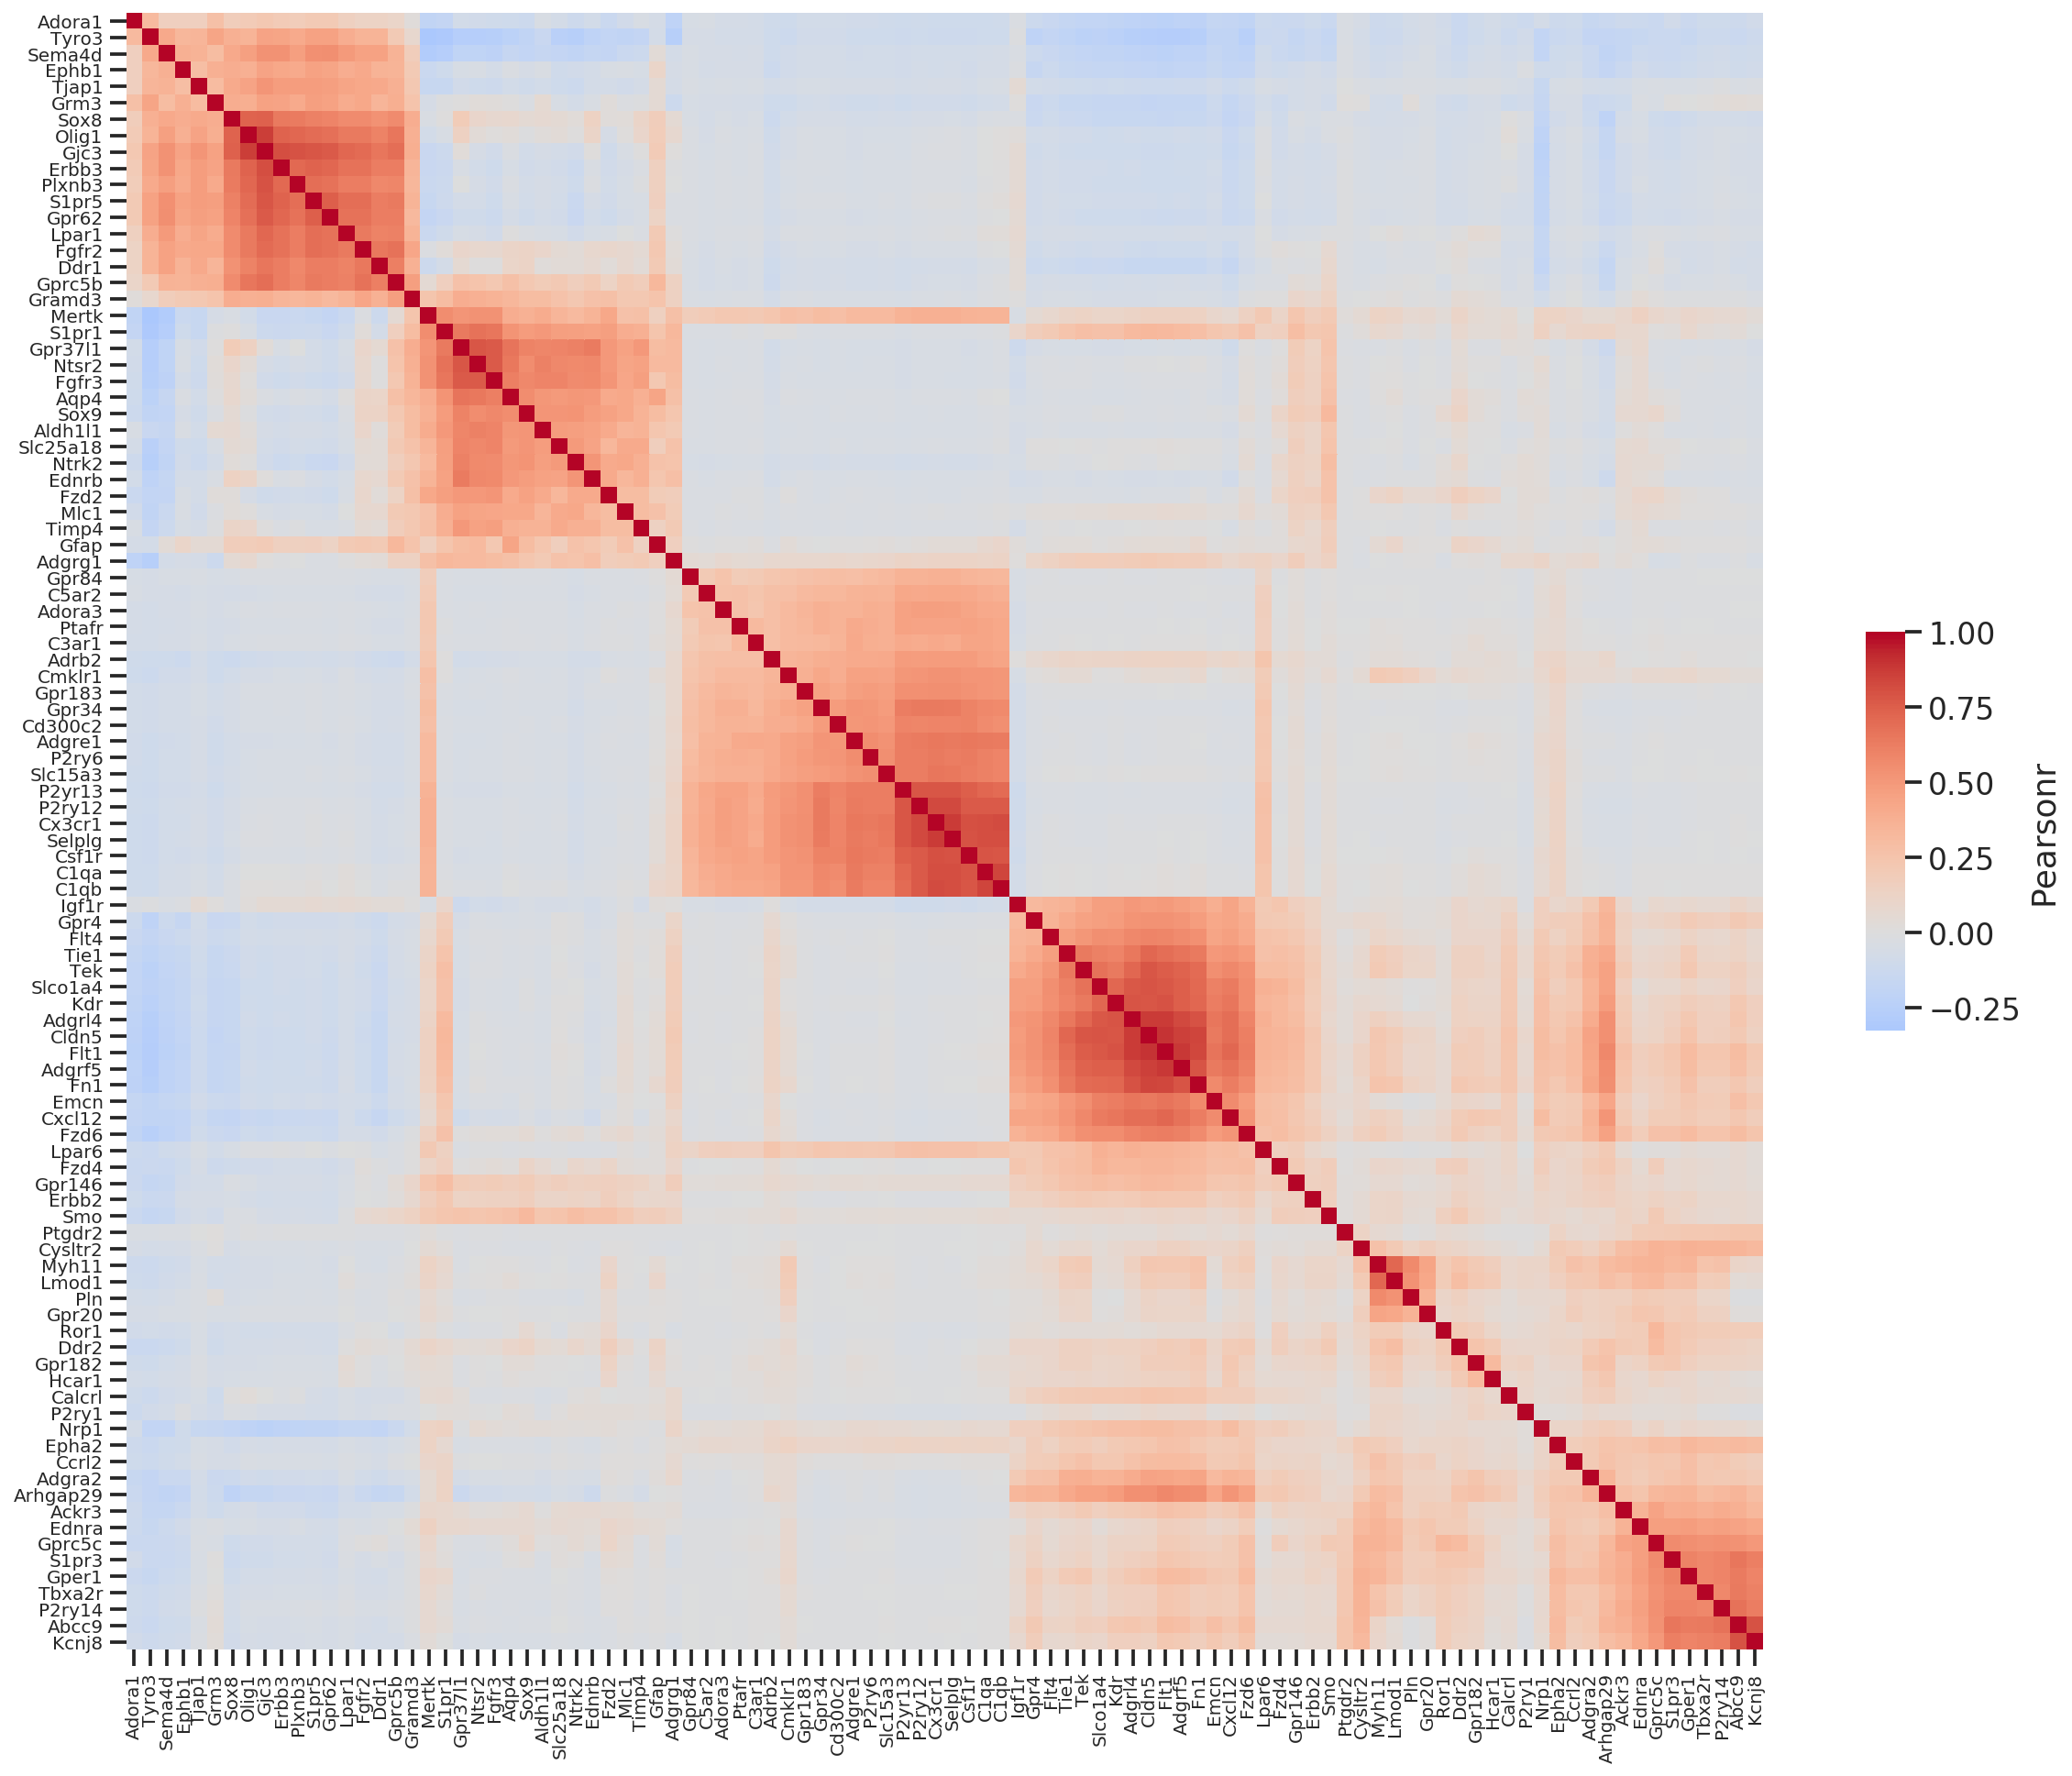

In [68]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ggcorr.iloc[d['leaves'], d['leaves']].iloc[:100,:100], 
            xticklabels=True,
            yticklabels=True,
            cbar_kws=dict(label='Pearsonr', aspect=10, shrink=0.2),
            cmap='coolwarm',
            center=0,
            ax=ax)
ax.set_aspect('equal')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.show()

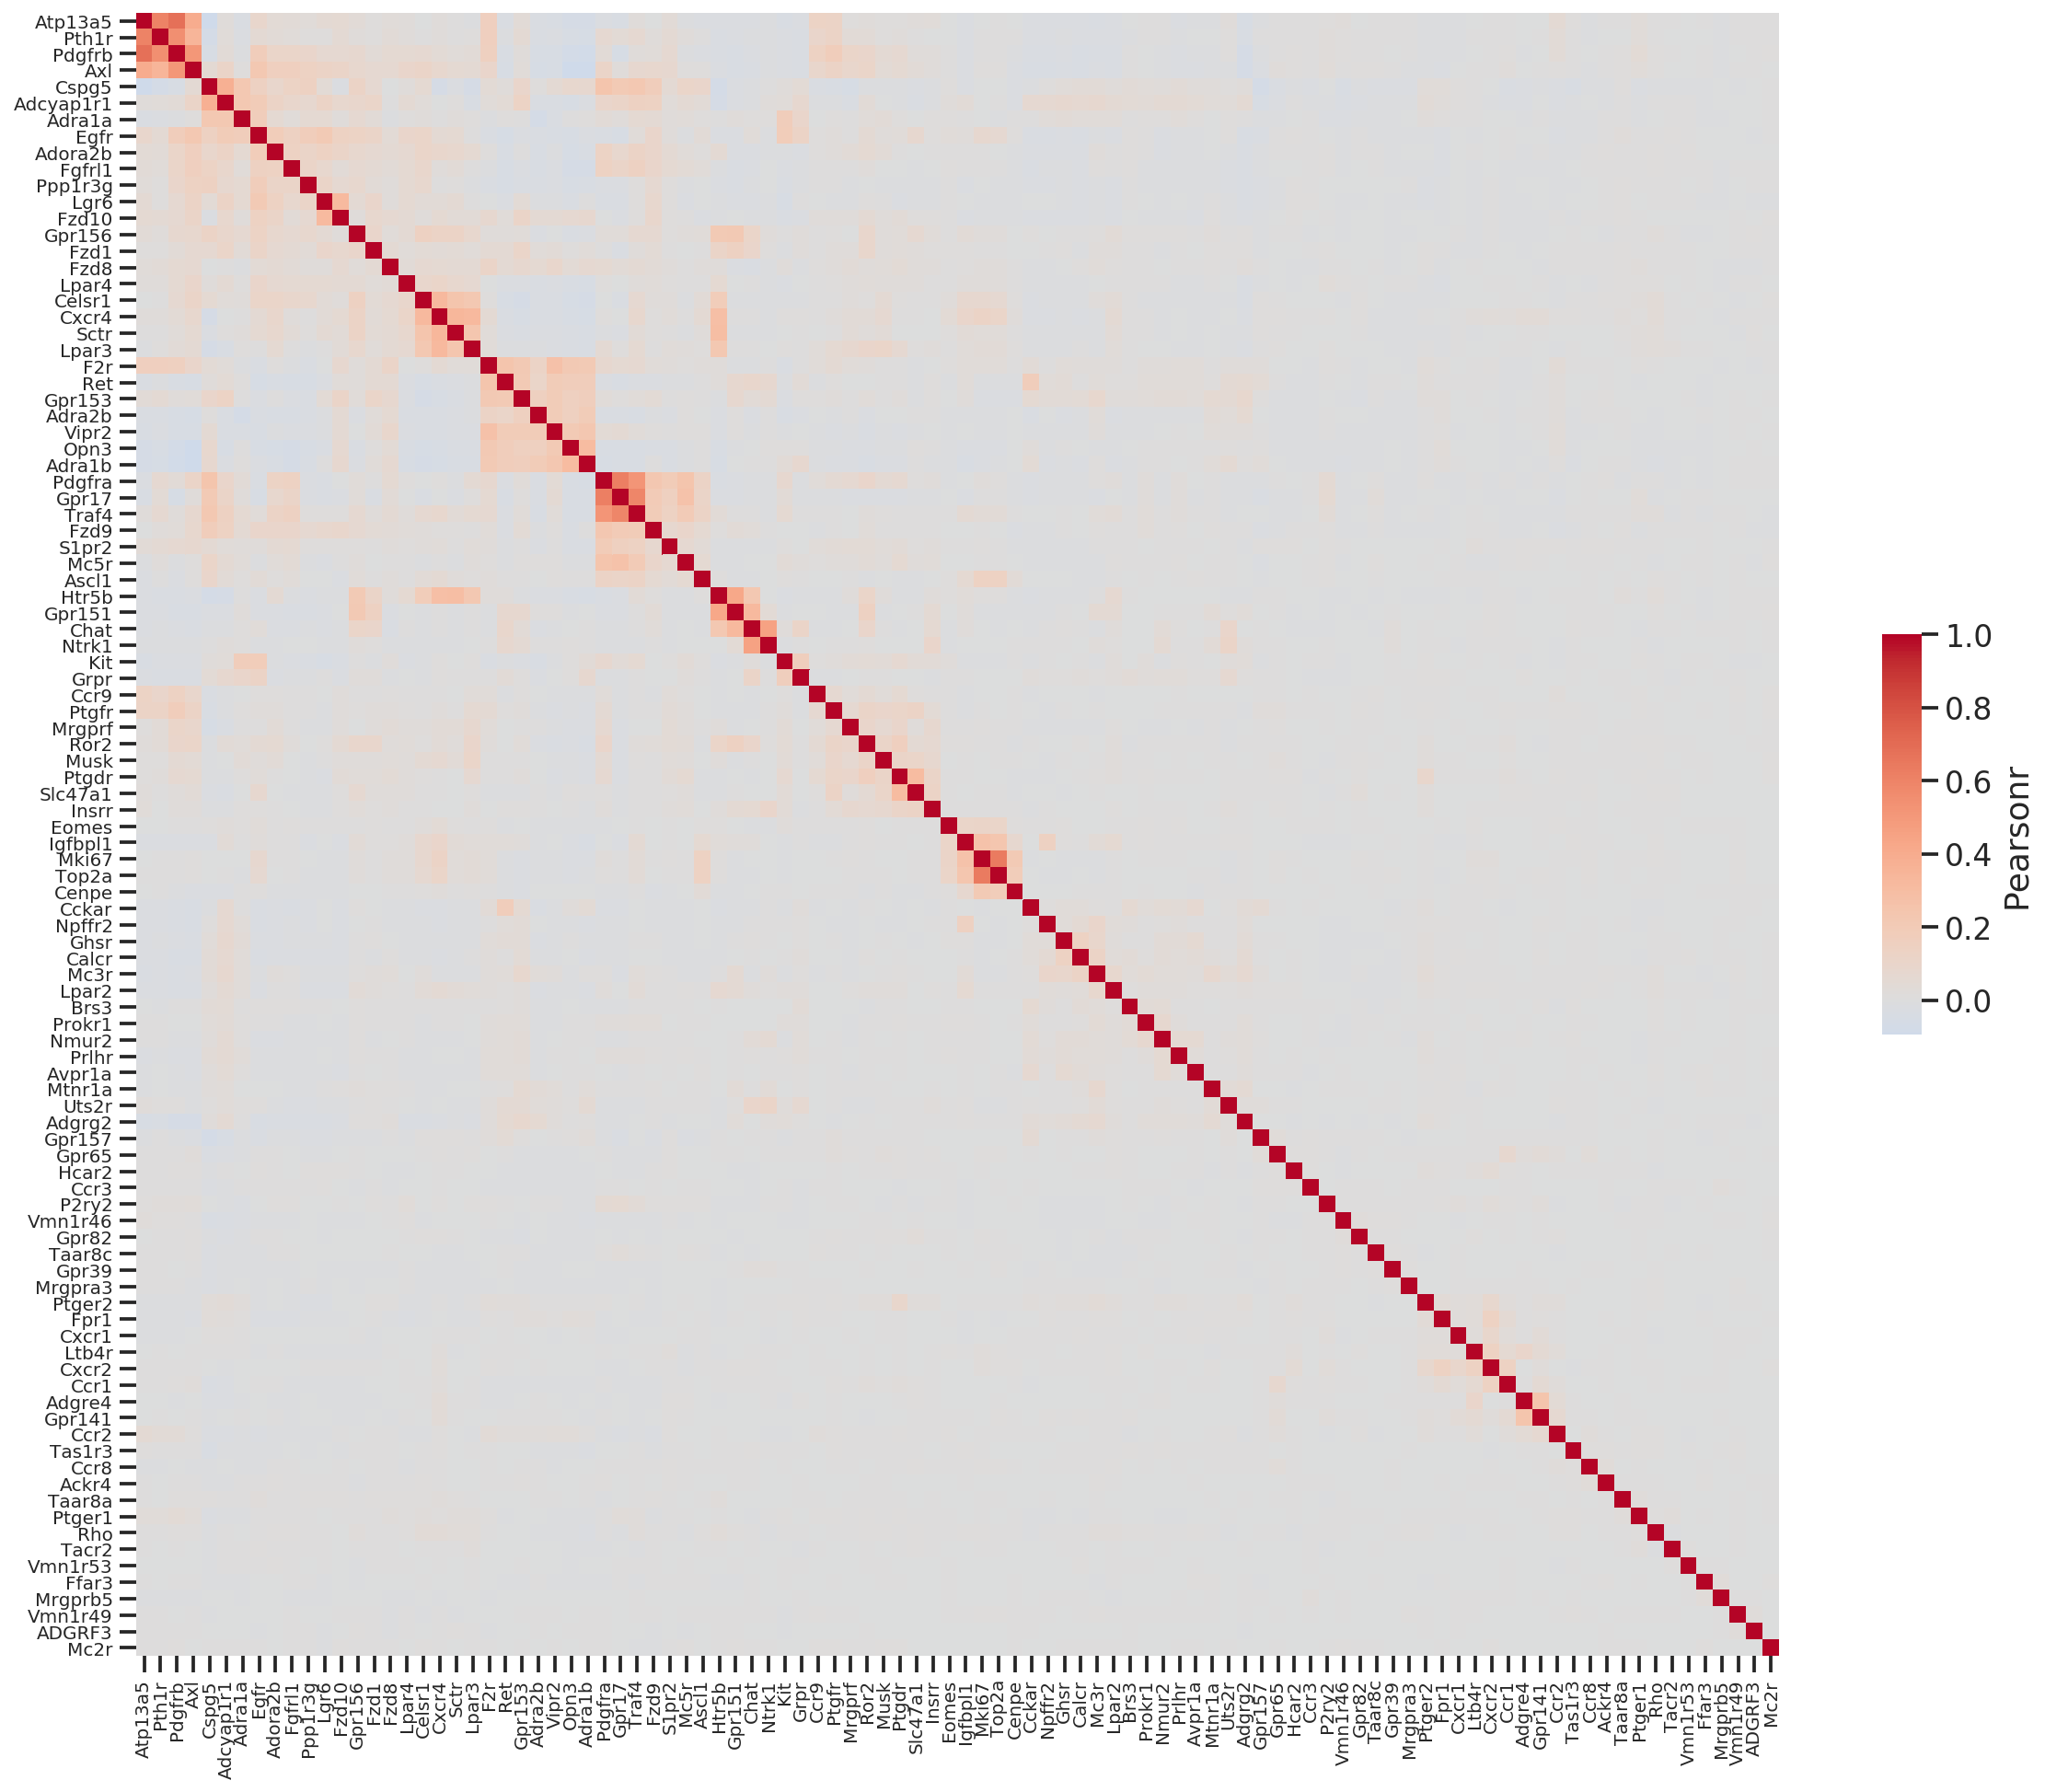

In [69]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ggcorr.iloc[d['leaves'], d['leaves']].iloc[100:200,100:200], 
            xticklabels=True,
            yticklabels=True,
            cbar_kws=dict(label='Pearsonr', aspect=10, shrink=0.2),
            cmap='coolwarm',
            center=0,
            ax=ax)
ax.set_aspect('equal')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.show()

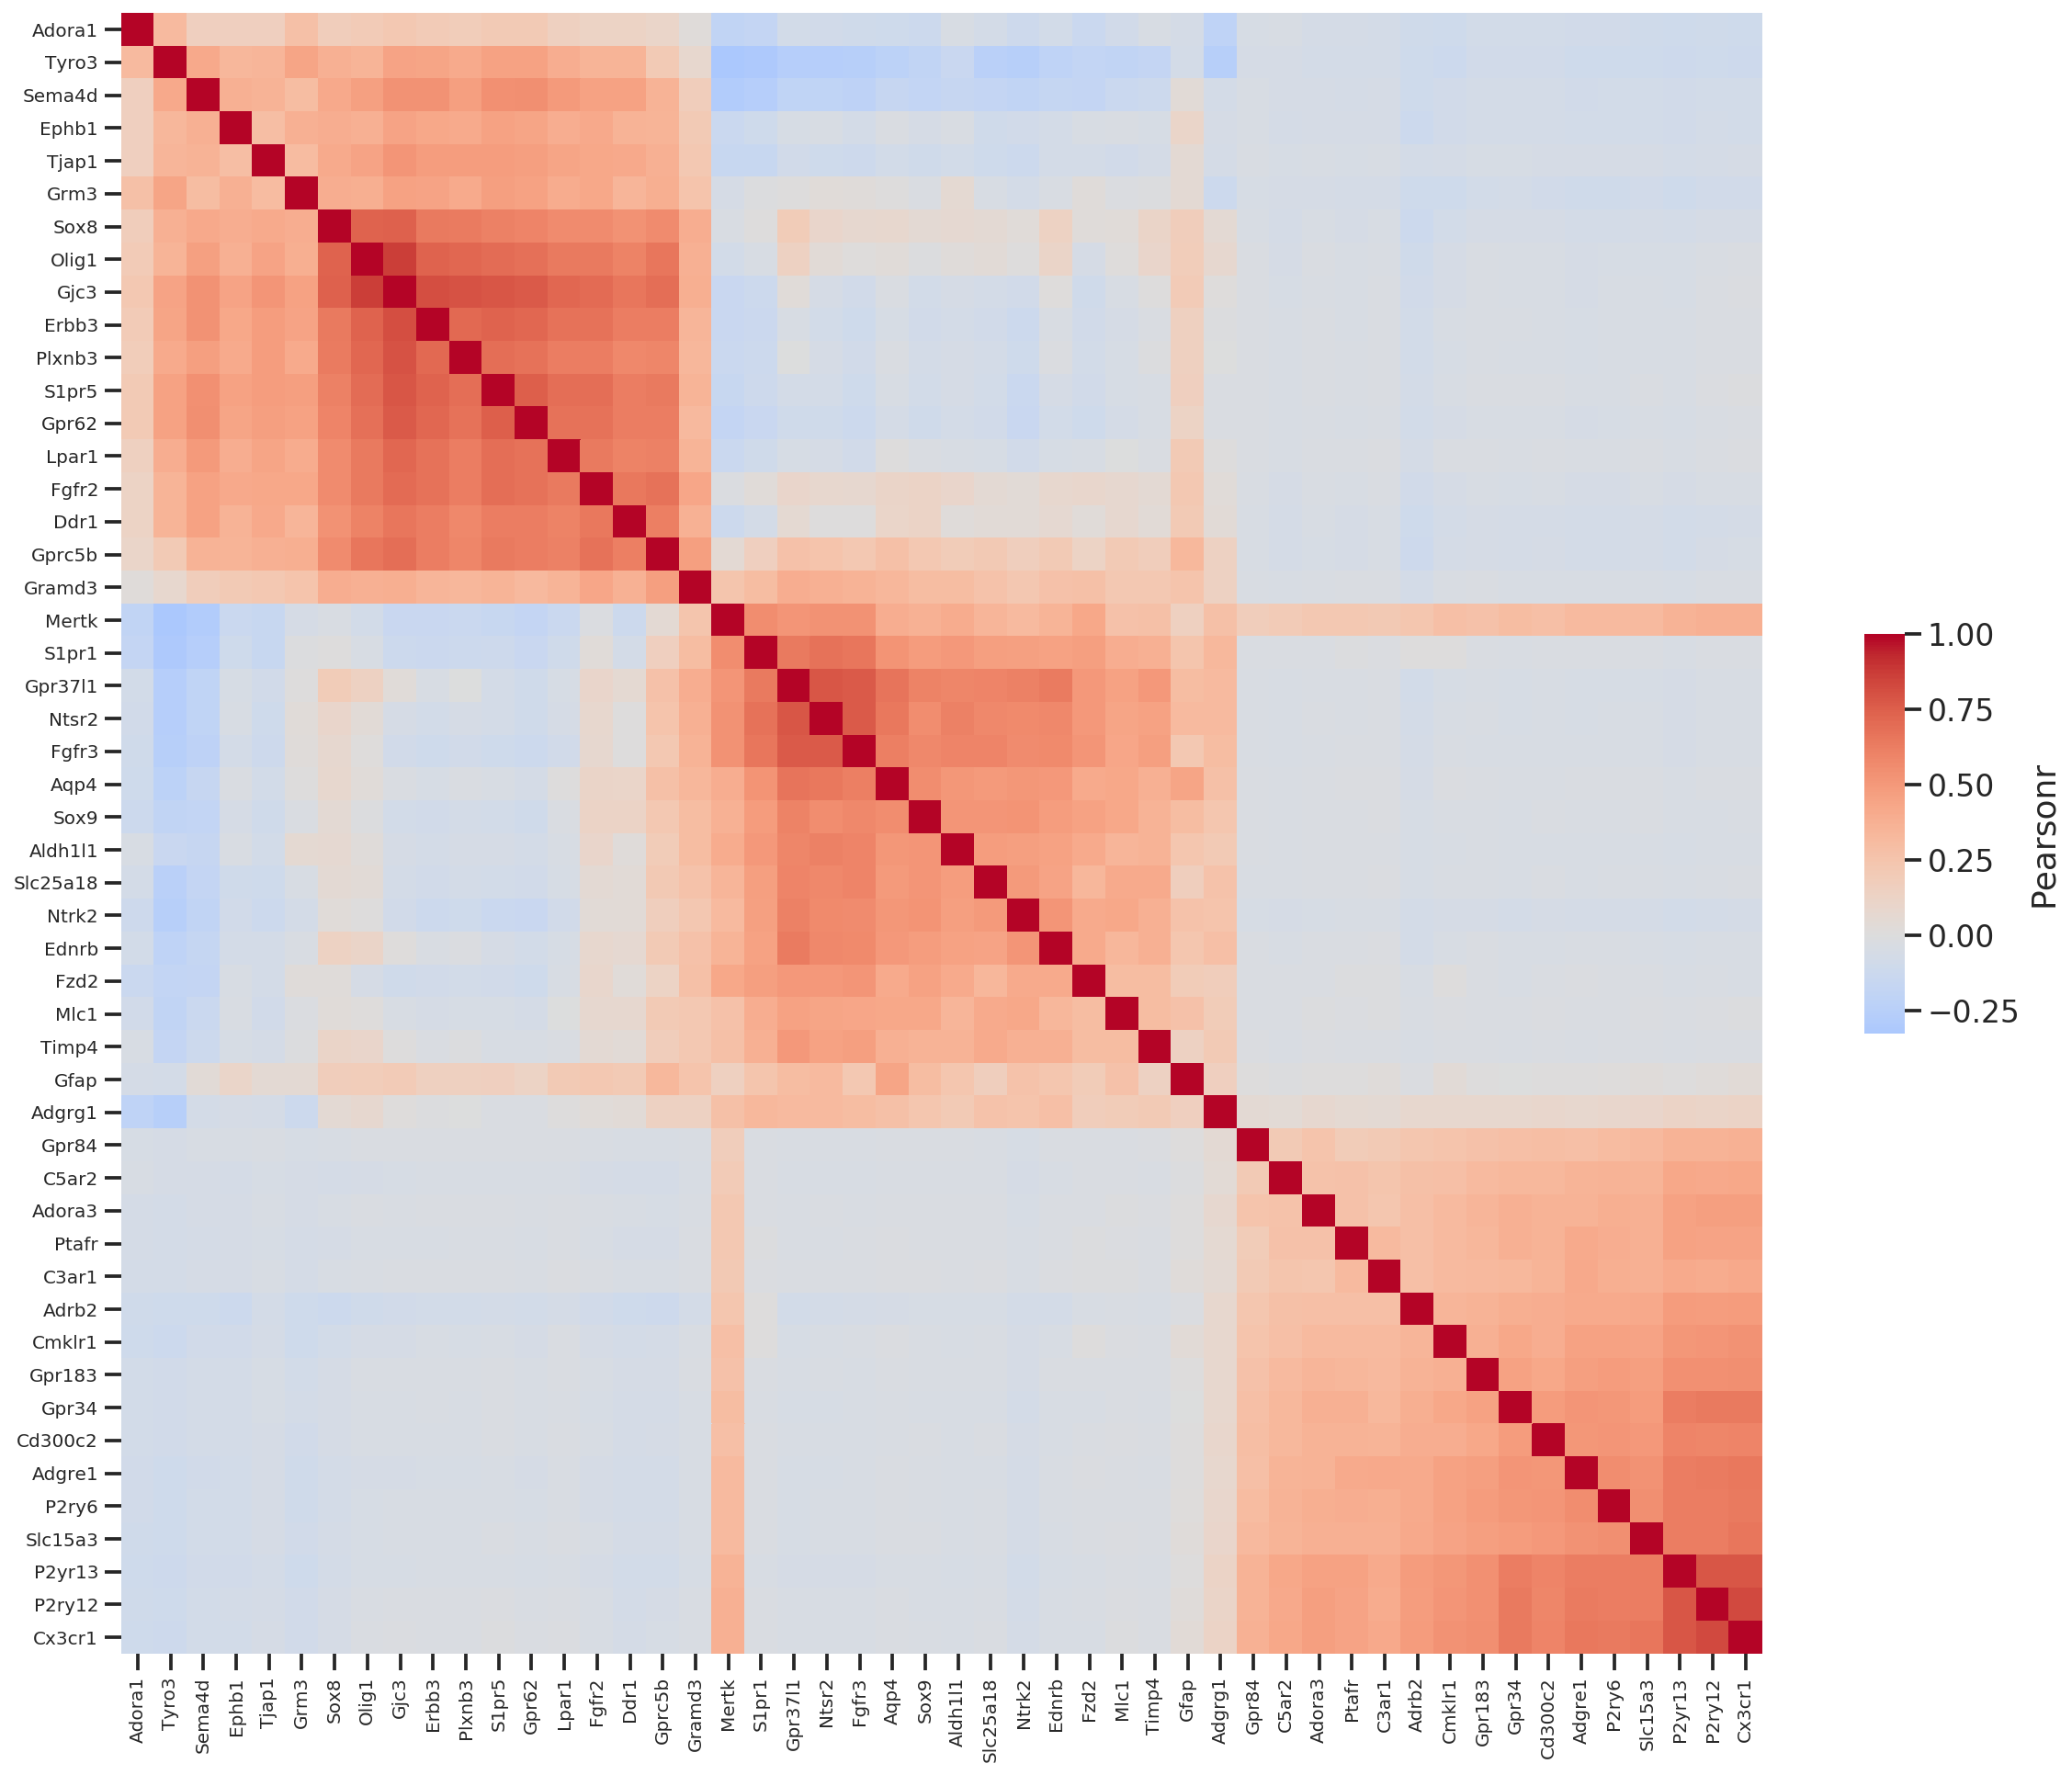

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ggcorr.iloc[d['leaves'], d['leaves']].iloc[:50,:50], 
            xticklabels=True,
            yticklabels=True,
            cbar_kws=dict(label='Pearsonr', aspect=10, shrink=0.2),
            cmap='coolwarm',
            center=0,
            ax=ax)
ax.set_aspect('equal')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.show()